# Import libraries

In [ ]:
!pip install ucimlrepo

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
import pickle as pkl
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from pprint import pprint
from ucimlrepo import fetch_ucirepo
from sklearn import preprocessing
from keras.callbacks import Callback
import json

# Define FourierDenseNet model

##V1


In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:


    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                for featureNum in range(series.shape[-1]):        # Each feature
                    features.append(series[i:i+windowSize, featureNum])
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        # global self.TargetComplexShape
        self.TargetComplexShape = ComplexValuedArray.shape
        # print(TARGET_COMPLEX_SHAPE)
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        # frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
        frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, mask=True, maskPercentage=0):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if mask:
                    maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                    # frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            # timeSeries.append(rollingWindowTimeSeries[i][-1])
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, univariate=False, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))

        self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage)

        self.originalX, self.originalY = self.rollingWindowTimeSeries[:-1], self.rollingWindowTimeSeries[:, -1][1:]
        self.X, self.y = self.rollingWindowFrequencies[:-1], self.rollingWindowFrequencies[:, -1][1:]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)
            # # Plotting the cumulative explained variance
            # plt.plot(np.cumsum(pcaObj.explained_variance_ratio_))
            # plt.xlabel('Number of Components')
            # plt.ylabel('Cumulative Explained Variance')
            # plt.title('Explained Variance vs. Number of Components')
            # plt.show()

            # Determine the number of components for 90% variance
            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1
            # print(f'Number of components for 90% variance: {n_components}')

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]
        print(self.originalX_test.shape, self.originalY_test.shape, self.X_test.shape, self.y_test.shape)


    def TrainSetup(self, hiddenLayers, hiddenUnits):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        self.model.summary()

    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
            ax.set_title(title_suffix)
        ax.set_xlabel('Date')
        # ax.set_ylabel(xlabel)
        ax.legend()
        plt.show()

    def driver(self, univariate=False, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95):
        initialTime = time()
        self.DataPreprocessor(univariate, trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio)
        self.TrainSetup(hiddenLayers, hiddenUnits)
        # return
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=[earlyStop])#, verbose=0)
        totalTime = time() - initialTime

        testPredictions = self.model.predict(self.X_test)

        pred = self.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, self.TargetComplexShape)
        actual = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)

        pred = self.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=1)
        actual = self.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=1)


        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)
        # print("Predicted:", predicted.shape)
        predicted = predicted.reshape(predicted.shape[0], 1)
        predicted = yScaler.inverse_transform(predicted)

        # expected = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)
        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        # expected = self.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=self.ForecastHorizon)
        # # print("Expected:", expected.shape)
        expected = expected.reshape(expected.shape[0], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        # information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "mse": mse, "num_params": self.model.count_params()}
        return information

##V2

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


class TimeLimitCallback(Callback):
    def __init__(self, time_limit):
        super(TimeLimitCallback, self).__init__()
        self.start_time = 0
        self.time_limit = time_limit

    def on_train_begin(self, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")


class FourierInformedTimeSeriesForecaster:

    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime):
        if ForecastHorizon>WindowSize:
            raise Exception("Forecast horizon must be lesser than window size")
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None
        self.MaskLower = MaskLower
        self.Univariate = Univariate
        self.TrainTime = TrainTime

    def seriesToRollingWindowSeries(self, series, windowSize):
        data = []
        for i in range(len(series)-windowSize):      # Each window
            features = []
            for featureNum in range(series.shape[-1]):        # Each feature
                features.append(series[i:i+windowSize, featureNum])
            data.append(features)
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        self.TargetComplexShape = ComplexValuedArray.shape
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        if self.MaskPercentage>0:
            if self.MaskLower:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
            else:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, maskPercentage=0, maskLower=True):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if maskPercentage>0:
                    if maskLower:
                        maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    else:
                        maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0][-forecastHorizon:])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95, verbose=True, excludeTargetInTraining=False, windowedInput=False):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))
        if windowedInput:
            self.rollingWindowTimeSeries = self.TimeSeries
        else:
            self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage, maskLower=self.MaskLower)
        if self.Univariate:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:]
        elif excludeTargetInTraining:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize, :-1], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize, :-1], self.rollingWindowFrequencies[self.WindowSize:, -1]
        else:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:, -1]
            # self.X, self.y = self.originalX, self.originalY ############################################### No frequency domain
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)

            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]

        if verbose:
            verbose_info = {}
            verbose_info['originalX_test_shape'] = self.originalX_test.shape
            verbose_info['originalY_test_shape'] = self.originalY_test.shape
            verbose_info['X_test_shape'] = self.X_test.shape
            verbose_info['y_test_shape'] = self.y_test.shape
            pprint(verbose_info)


    def TrainSetup(self, hiddenLayers, hiddenUnits, verbose):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        if verbose:
            self.model.summary()


    def driver(self, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95, verbose=True, targetScaler=None, excludeTargetInTraining=False):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio, verbose=verbose, excludeTargetInTraining=excludeTargetInTraining)
        self.TrainSetup(hiddenLayers, hiddenUnits, verbose)
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        callbacks = [earlyStop]
        if self.TrainTime > 0:
            time_limit_callback = TimeLimitCallback(time_limit=self.TrainTime)
            callbacks.append(time_limit_callback)
        if verbose:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks)#, verbose=0)
        else:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks, verbose=0)
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)    ######################### No frequencies
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)

        predicted = predicted.reshape(predicted.shape[0], 1)
        if targetScaler:
            predicted = targetScaler.inverse_transform(predicted)

        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        expected = expected.reshape(expected.shape[0], 1)
        if targetScaler:
            expected = targetScaler.inverse_transform(expected)


        rmse = (((expected - predicted)**2).mean())**0.5

        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "rmse": rmse, "num_params": self.model.count_params(), "trainHistory":trainHistory.history}
        return information

#V2 - TimeDenseNet

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


class TimeLimitCallback(Callback):
    def __init__(self, time_limit):
        super(TimeLimitCallback, self).__init__()
        self.start_time = 0
        self.time_limit = time_limit

    def on_train_begin(self, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")


class TimeInformedTimeSeriesForecaster:

    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime):
        if ForecastHorizon>WindowSize:
            raise Exception("Forecast horizon must be lesser than window size")
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None
        self.MaskLower = MaskLower
        self.Univariate = Univariate
        self.TrainTime = TrainTime

    def seriesToRollingWindowSeries(self, series, windowSize):
        data = []
        for i in range(len(series)-windowSize):      # Each window
            features = []
            for featureNum in range(series.shape[-1]):        # Each feature
                features.append(series[i:i+windowSize, featureNum])
            data.append(features)
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        self.TargetComplexShape = ComplexValuedArray.shape
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        if self.MaskPercentage>0:
            if self.MaskLower:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
            else:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, maskPercentage=0, maskLower=True):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if maskPercentage>0:
                    if maskLower:
                        maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    else:
                        maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0][-forecastHorizon:])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95, verbose=True, excludeTargetInTraining=False, windowedInput=False):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))
        if windowedInput:
            self.rollingWindowTimeSeries = self.TimeSeries
        else:
            self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage, maskLower=self.MaskLower)
        if self.Univariate:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:]
        elif excludeTargetInTraining:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize, :-1], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize, :-1], self.rollingWindowFrequencies[self.WindowSize:, -1]
        else:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:, -1]
            self.X, self.y = self.originalX, self.originalY ############################################### No frequency domain
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)

            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]

        if verbose:
            verbose_info = {}
            verbose_info['originalX_test_shape'] = self.originalX_test.shape
            verbose_info['originalY_test_shape'] = self.originalY_test.shape
            verbose_info['X_test_shape'] = self.X_test.shape
            verbose_info['y_test_shape'] = self.y_test.shape
            pprint(verbose_info)


    def TrainSetup(self, hiddenLayers, hiddenUnits, verbose):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        if verbose:
            self.model.summary()


    def driver(self, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95, verbose=True, targetScaler=None, excludeTargetInTraining=False):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio, verbose=verbose, excludeTargetInTraining=excludeTargetInTraining)
        self.TrainSetup(hiddenLayers, hiddenUnits, verbose)
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        callbacks = [earlyStop]
        if self.TrainTime > 0:
            time_limit_callback = TimeLimitCallback(time_limit=self.TrainTime)
            callbacks.append(time_limit_callback)
        if verbose:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks)#, verbose=0)
        else:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=callbacks, verbose=0)
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        # predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)    ######################### No frequencies
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)

        predicted = predicted.reshape(predicted.shape[0], 1)
        if targetScaler:
            predicted = targetScaler.inverse_transform(predicted)

        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        expected = expected.reshape(expected.shape[0], 1)
        if targetScaler:
            expected = targetScaler.inverse_transform(expected)


        rmse = (((expected - predicted)**2).mean())**0.5

        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "rmse": rmse, "num_params": self.model.count_params(), "trainHistory":trainHistory.history}
        return information

#V2 (X, y separate inputs for CMAPSS)

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:          # Windowed Input

    def __init__(self, X, y, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate):
        if ForecastHorizon>WindowSize:
            raise Exception("Forecast horizon must be lesser than window size")
        # self.TimeSeries = TimeSeries
        self.X = X
        self.y = y
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None
        self.MaskLower = MaskLower
        self.Univariate = Univariate

    def seriesToRollingWindowSeries(self, series, windowSize):
        data = []
        for i in range(len(series)-windowSize):      # Each window
            features = []
            for featureNum in range(series.shape[-1]):        # Each feature
                features.append(series[i:i+windowSize, featureNum])
            data.append(features)
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        self.TargetComplexShape = ComplexValuedArray.shape
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        if self.MaskPercentage>0:
            if self.MaskLower:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
            else:
                frequencyMagnitudes = np.pad(frequencyMagnitudes, (0, self.WindowSize - len(frequencyMagnitudes)), 'constant')
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, maskPercentage=0, maskLower=True):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if maskPercentage>0:
                    if maskLower:
                        maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                    else:
                        maskIndex = int(len(frequencyMagnitudes)*(1-maskPercentage))
                        frequencyMagnitudes = frequencyMagnitudes[:maskIndex]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0][-forecastHorizon:])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2, usePCA=True, pcaVarExpRatio=0.95, verbose=True, excludeTargetInTraining=False, windowedInput=False):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))
        self.rollingWindowTimeSeries = self.TimeSeries
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage, maskLower=self.MaskLower)
        if self.Univariate:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:]
        elif excludeTargetInTraining:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize, :-1], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize, :-1], self.rollingWindowFrequencies[self.WindowSize:, -1]
        else:
            self.originalX, self.originalY = self.rollingWindowTimeSeries[:-self.WindowSize], self.rollingWindowTimeSeries[self.WindowSize:, -1]
            self.X, self.y = self.rollingWindowFrequencies[:-self.WindowSize], self.rollingWindowFrequencies[self.WindowSize:, -1]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if usePCA:
            pcaObj = PCA().fit(self.X)

            cumulative_variance_ratio = np.cumsum(pcaObj.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance_ratio >= pcaVarExpRatio) + 1

            covar_matrix = PCA(n_components = n_components)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.originalX_train, self.originalY_train = self.originalX[:trainSplitIndex], self.originalY[:trainSplitIndex]
        self.originalX_val, self.originaly_val = self.originalX[trainSplitIndex:valSplitIndex], self.originalY[trainSplitIndex:valSplitIndex]
        self.originalX_test, self.originalY_test = self.originalX[valSplitIndex:], self.originalY[valSplitIndex:]

        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]

        if verbose:
            verbose_info = {}
            verbose_info['originalX_test_shape'] = self.originalX_test.shape
            verbose_info['originalY_test_shape'] = self.originalY_test.shape
            verbose_info['X_test_shape'] = self.X_test.shape
            verbose_info['y_test_shape'] = self.y_test.shape
            pprint(verbose_info)


    def TrainSetup(self, hiddenLayers, hiddenUnits, verbose):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        if verbose:
            self.model.summary()


    def driver(self, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, usePCA=True, pcaVarExpRatio=0.95, verbose=True, targetScaler=None, excludeTargetInTraining=False):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio, usePCA=usePCA, pcaVarExpRatio=pcaVarExpRatio, verbose=verbose, excludeTargetInTraining=excludeTargetInTraining)
        self.TrainSetup(hiddenLayers, hiddenUnits, verbose)
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=5)
        if verbose:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=[earlyStop])#, verbose=0)
        else:
            trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val), callbacks=[earlyStop], verbose=0)
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)

        predicted = predicted.reshape(predicted.shape[0], 1)
        if targetScaler:
            predicted = targetScaler.inverse_transform(predicted)

        expected = self.rollingWindowTimeSeriesToTimeSeries(self.originalY_test, forecastHorizon=self.ForecastHorizon)
        expected = expected.reshape(expected.shape[0], 1)
        if targetScaler:
            expected = targetScaler.inverse_transform(expected)


        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "timeTaken": totalTime, "mse": mse, "num_params": self.model.count_params()}
        return information

# Helper functions

In [ ]:
def evaluate(expected, predicted):
    mse = mean_squared_error(expected, predicted)
    mae = mean_absolute_error(expected, predicted)
    r2 = r2_score(expected, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((expected - predicted) / expected)) * 100

    results = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R-squared': r2,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape
    }


    # Plot expected vs predicted values
    plt.figure(figsize=(8, 4))
    plt.plot(expected, label='Expected', color='blue')
    plt.plot(predicted, label='Predicted', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('Demand')
    plt.title('Expected vs Predicted Demand')
    plt.legend()
    plt.show()

    pprint(results)
    return results

# Dataset 1

In [ ]:
import shutil
os.environ['KAGGLE_CONFIG_DIR'] = 'drive/MyDrive/Kaggle'
!kaggle datasets download -d pateljay731/panama-electricity-load-forecasting
!unzip -q panama-electricity-load-forecasting.zip -d data
!rm panama-electricity-load-forecasting.zip

Dataset URL: https://www.kaggle.com/datasets/pateljay731/panama-electricity-load-forecasting
License(s): unknown
  0% 0.00/2.98M [00:00<?, ?B/s]
100% 2.98M/2.98M [00:00<00:00, 85.1MB/s]


## Load dataset


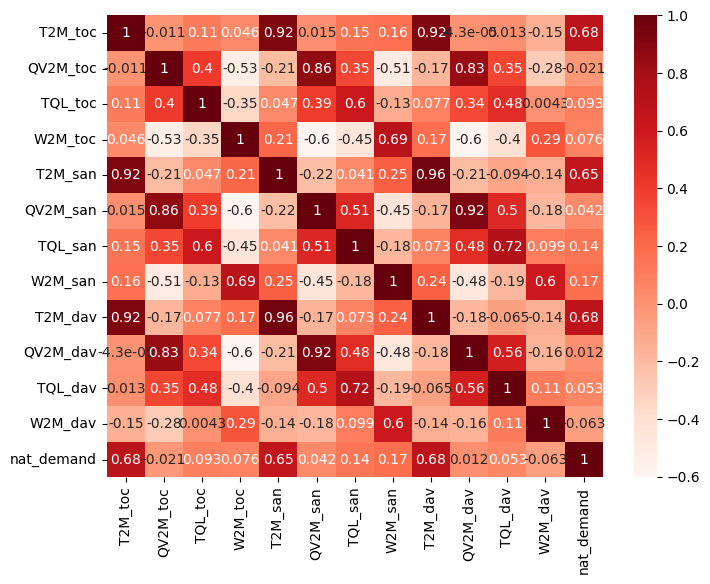

In [ ]:

df = pd.read_csv("data/train.csv",
                 parse_dates=["datetime"],
                 index_col=["datetime"])
df = df[[c for c in df if c not in ['nat_demand']] + ['nat_demand']]
col=['Holiday_ID','holiday', 'school']
df= df.drop(columns=col)

plt.figure(figsize=(8,6))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

corr_matrix = df.corr()
high_corr_cols = corr_matrix[abs(corr_matrix['nat_demand']) > 0.5].index
df = df[high_corr_cols].copy()


xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['nat_demand']]] = xScaler.fit_transform(df[[c for c in df if c not in ['nat_demand']]])
df[["nat_demand"]] = yScaler.fit_transform(df[["nat_demand"]])

## Initialize model parameters

In [ ]:
df[["nat_demand"]].values

array([[0.5409399 ],
       [0.50539099],
       [0.49811449],
       ...,
       [0.67742589],
       [0.63878884],
       [0.61068694]])

In [ ]:
# Data = df[["nat_demand"]].values[:10000]
Data = df.values[:10000]
WindowSize = 100
ForecastHorizon = 50
MaskPercentage = 0.0
TrainRatio = 0.8
ValRatio = 0.1
HiddenLayers = 8
HiddenUnits = 12
Epochs = 50
UsePca = False
PcaVarExpRatio = 0.99
MaskLower = False
Univariate = False
ExcludeTargetInTraining = True
TrainTime = 300

##Run trainings

In [ ]:
information["expected"].shape

NameError: name 'information' is not defined

In [ ]:
# fourierModule.y.shape
fourierModule.X_train.shape

(8000, 72)

{'X_test_shape': (800, 600),
 'originalX_test_shape': (800, 3, 100),
 'originalY_test_shape': (800, 100),
 'y_test_shape': (800, 200)}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                7212      
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 12)                156       
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 12)              

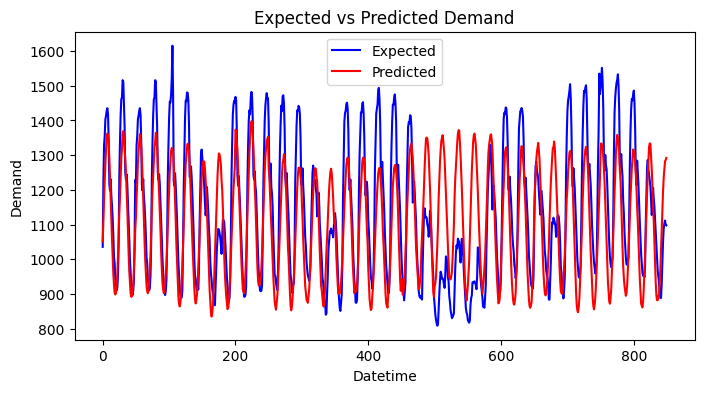

{'Mean Absolute Error': 111.66267624366516,
 'Mean Absolute Percentage Error': 9.840270996103552,
 'Mean Squared Error': 18817.00809878214,
 'R-squared': 0.488838924176742,
 'Root Mean Squared Error': 137.17510014132353}


In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio,
                                   excludeTargetInTraining=ExcludeTargetInTraining, targetScaler=yScaler)#, verbose=False)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

plot of training time vs training accuracy
figure that increasing time, training accuracy increases
every epoch, plt train loss and val loss

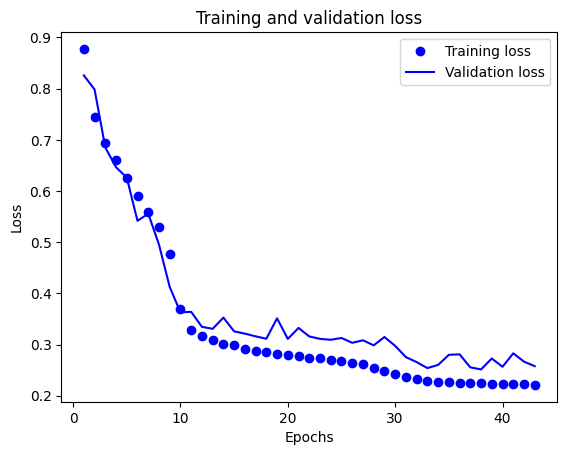

In [ ]:
def plot_loss_curve(history):
    train_loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming train_history is your training history object
plot_loss_curve(information["trainHistory"])

check results with varying window sizes and forecast horizon comapring both models

{'X_test_shape': (800, 600),
 'originalX_test_shape': (800, 3, 100),
 'originalY_test_shape': (800, 100),
 'y_test_shape': (800, 200)}
Model: "sequential_438"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3942 (Dense)          (None, 12)                7212      
                                                                 
 dense_3943 (Dense)          (None, 12)                156       
                                                                 
 dense_3944 (Dense)          (None, 12)                156       
                                                                 
 dense_3945 (Dense)          (None, 12)                156       
                                                                 
 dense_3946 (Dense)          (None, 12)                156       
                                                                 
 dense_3947 (Dense)          (None, 12)          

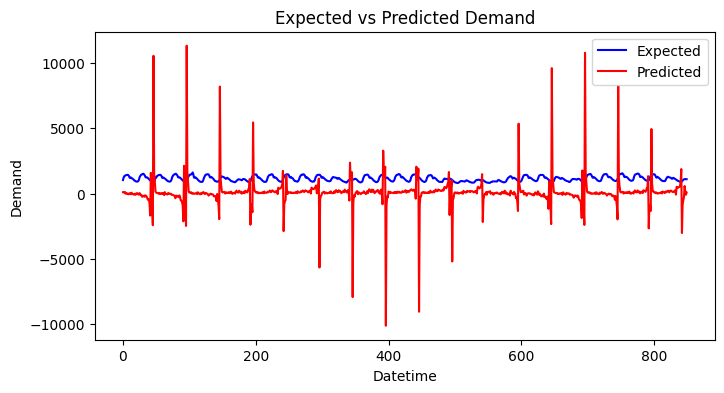

{'Mean Absolute Error': 1232.6001453537417,
 'Mean Absolute Percentage Error': 109.31322646586649,
 'Mean Squared Error': 2540167.216391686,
 'R-squared': -68.00324431415753,
 'Root Mean Squared Error': 1593.7902046353797}


In [ ]:
timeModule = TimeInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime)
information = timeModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio,
                                   excludeTargetInTraining=ExcludeTargetInTraining, targetScaler=yScaler)#, verbose=False)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

{'X_test_shape': (800, 600),
 'originalX_test_shape': (800, 3, 100),
 'originalY_test_shape': (800, 100),
 'y_test_shape': (800, 200)}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 12)                7212      
                                                                 
 dense_68 (Dense)            (None, 12)                156       
                                                                 
 dense_69 (Dense)            (None, 12)                156       
                                                                 
 dense_70 (Dense)            (None, 12)                156       
                                                                 
 dense_71 (Dense)            (None, 12)                156       
                                                                 
 dense_72 (Dense)            (None, 12)            

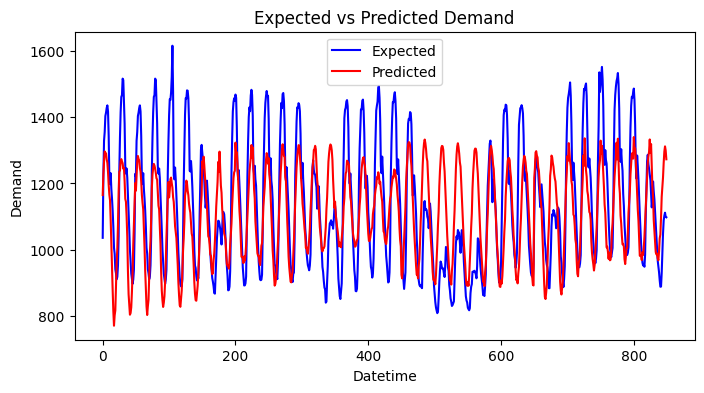

{'Mean Absolute Error': 119.96579904914097,
 'Mean Absolute Percentage Error': 10.482495956594066,
 'Mean Squared Error': 21483.338346347206,
 'R-squared': 0.41640848089422766,
 'Root Mean Squared Error': 146.57195620700165}


In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio,
                                   excludeTargetInTraining=ExcludeTargetInTraining, targetScaler=yScaler)#, verbose=False)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

25/25 [==============================] - 0s 1ms/step


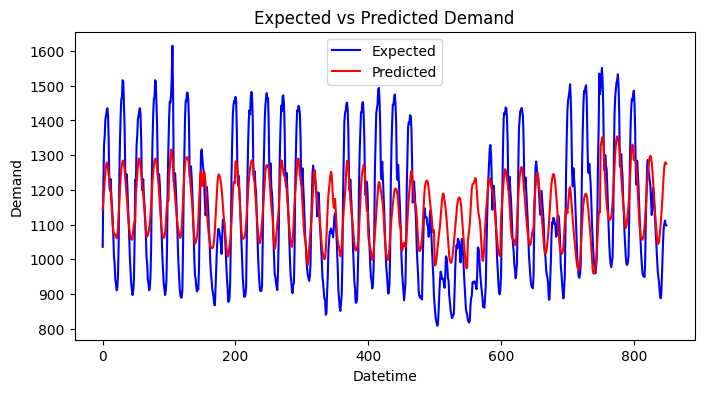

{'Mean Absolute Error': 111.54646777977068,
 'Mean Absolute Percentage Error': 10.031031372419912,
 'Mean Squared Error': 17939.68520920019,
 'R-squared': 0.512671262969863,
 'Root Mean Squared Error': 133.93911008066385}
25/25 [==============================] - 0s 1ms/step


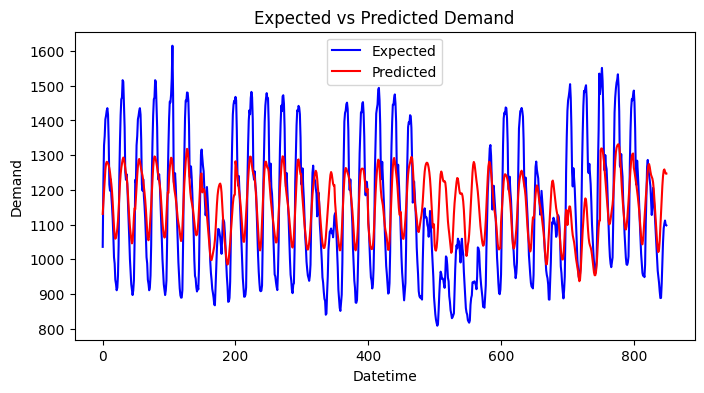

{'Mean Absolute Error': 116.449350726659,
 'Mean Absolute Percentage Error': 10.596369640191146,
 'Mean Squared Error': 19784.74447256587,
 'R-squared': 0.46255051725573915,
 'Root Mean Squared Error': 140.65825419279835}
25/25 [==============================] - 0s 1ms/step


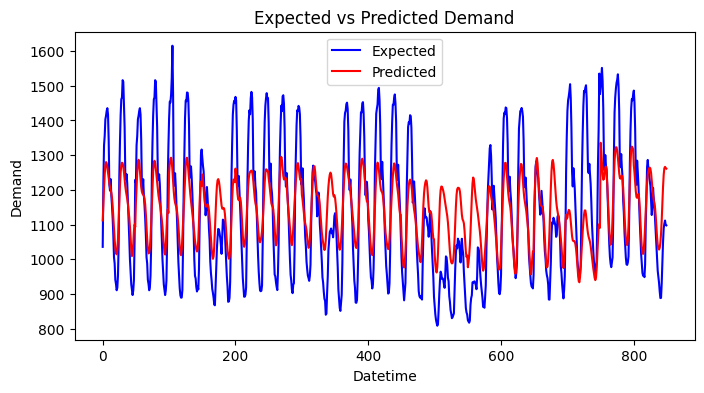

{'Mean Absolute Error': 108.69080324365142,
 'Mean Absolute Percentage Error': 9.662905665742036,
 'Mean Squared Error': 17453.786566165836,
 'R-squared': 0.5258706234532428,
 'Root Mean Squared Error': 132.11277972310566}
Epoch 15: early stopping
25/25 [==============================] - 0s 1ms/step


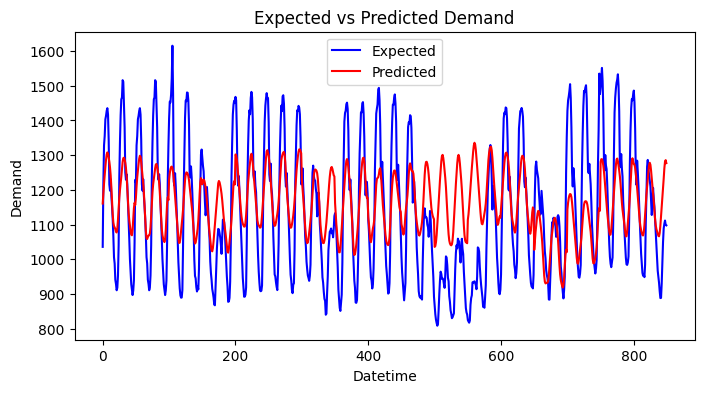

{'Mean Absolute Error': 121.85591665710605,
 'Mean Absolute Percentage Error': 11.183678042864848,
 'Mean Squared Error': 22049.72412910664,
 'R-squared': 0.4010226998749248,
 'Root Mean Squared Error': 148.49149514065323}
25/25 [==============================] - 0s 1ms/step


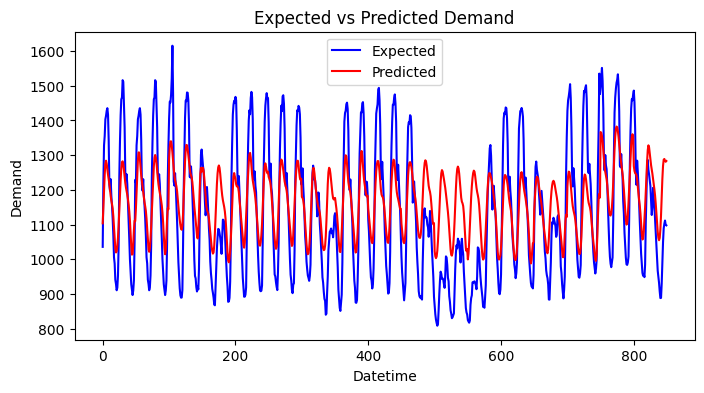

{'Mean Absolute Error': 111.81285310836157,
 'Mean Absolute Percentage Error': 10.238787962523507,
 'Mean Squared Error': 17730.751351598068,
 'R-squared': 0.5183469184655269,
 'Root Mean Squared Error': 133.15686745939192}
25/25 [==============================] - 0s 1ms/step


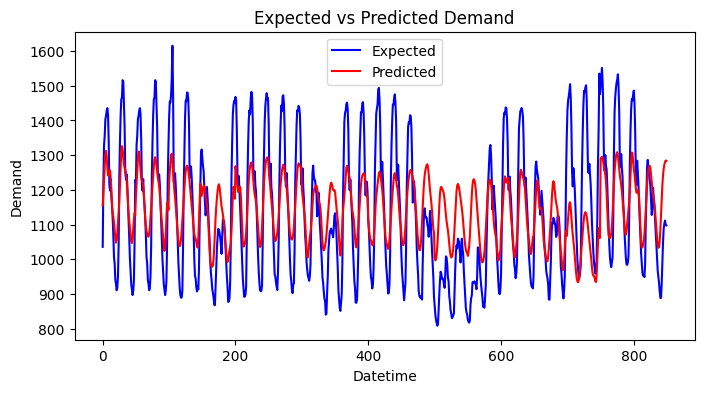

{'Mean Absolute Error': 112.93061058137641,
 'Mean Absolute Percentage Error': 10.100616499149854,
 'Mean Squared Error': 18719.817555032227,
 'R-squared': 0.4914790900650836,
 'Root Mean Squared Error': 136.82038428184677}
25/25 [==============================] - 0s 1ms/step


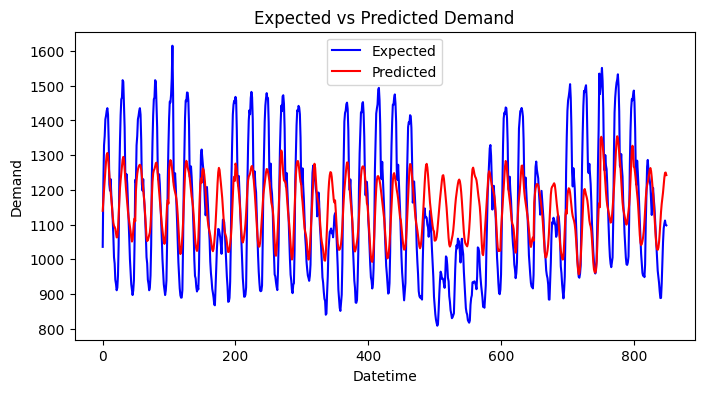

{'Mean Absolute Error': 111.93183587916333,
 'Mean Absolute Percentage Error': 10.133133855117363,
 'Mean Squared Error': 18428.64113701758,
 'R-squared': 0.49938885182451875,
 'Root Mean Squared Error': 135.75213124300325}
25/25 [==============================] - 0s 1ms/step


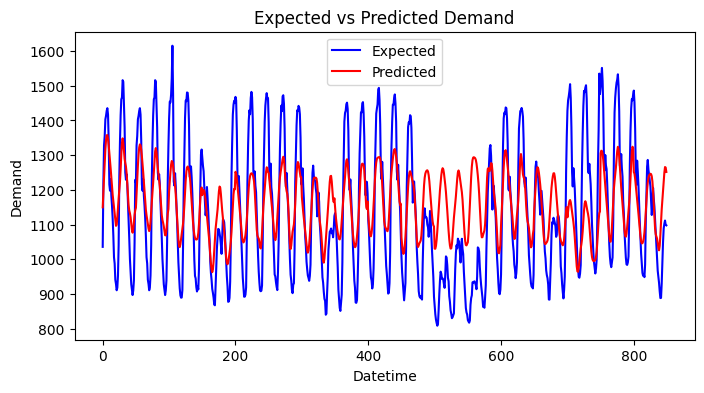

{'Mean Absolute Error': 116.45773842575032,
 'Mean Absolute Percentage Error': 10.639558011924874,
 'Mean Squared Error': 19972.87916719896,
 'R-squared': 0.45743986776228684,
 'Root Mean Squared Error': 141.32543708476177}
25/25 [==============================] - 0s 1ms/step


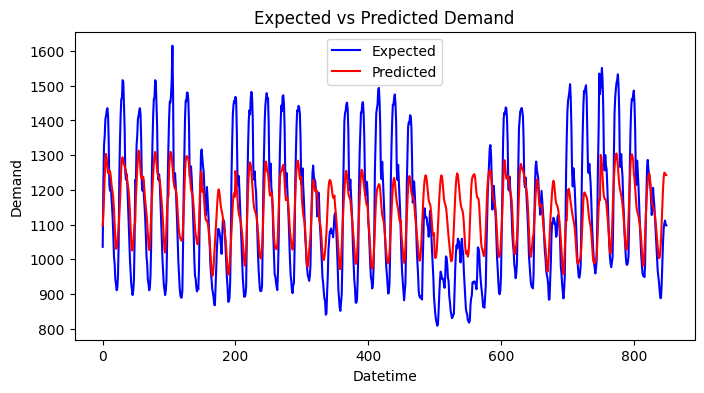

{'Mean Absolute Error': 108.44145234441588,
 'Mean Absolute Percentage Error': 9.631212318428883,
 'Mean Squared Error': 17364.959898241486,
 'R-squared': 0.528283585965649,
 'Root Mean Squared Error': 131.77617348459276}
25/25 [==============================] - 0s 2ms/step


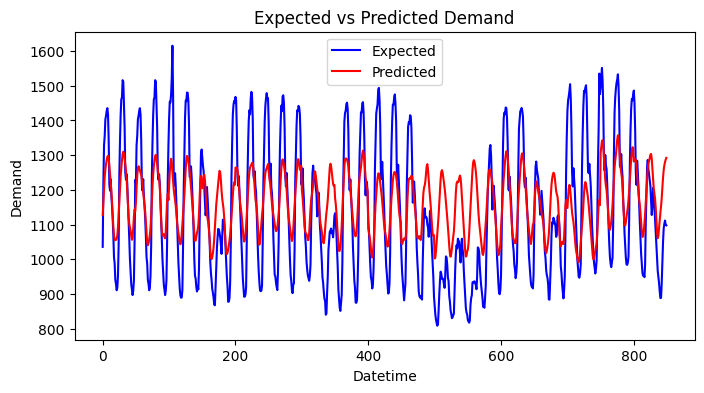

{'Mean Absolute Error': 114.86425034118747,
 'Mean Absolute Percentage Error': 10.509344946451222,
 'Mean Squared Error': 19041.771445458297,
 'R-squared': 0.4827332630913298,
 'Root Mean Squared Error': 137.99192529078758}


In [ ]:
evaluations = []
for i in range(10):
    fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate)
    information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio,
                                   excludeTargetInTraining=ExcludeTargetInTraining, targetScaler=yScaler, verbose=False)
    evaluation = evaluate(information["expected"], information["predicted"])
    evaluations.append(evaluation)

In [ ]:
sum_dict = {key: 0 for key in evaluations[0].keys()}
sum_squares_dict = {key: 0 for key in evaluations[0].keys()}

# Calculate the sum and sum of squares of values for each key
for ev in evaluations:
    for key, value in ev.items():
        sum_dict[key] += value
        sum_squares_dict[key] += value ** 2

# Calculate the mean and standard deviation for each key
num_dicts = len(evaluations)
mean_dict = {key: sum_value / num_dicts for key, sum_value in sum_dict.items()}
std_dict = {key: np.sqrt((sum_squares_dict[key] / num_dicts) - (mean_dict[key] ** 2)) for key in sum_dict.keys()}

# Combine mean and std into a tuple under the same key
average_dict = {key: (mean_dict[key], std_dict[key]) for key in mean_dict.keys()}

pprint(average_dict)

{'Mean Absolute Error': (113.49812790874421, 3.837873721804035),
 'Mean Absolute Percentage Error': (10.272663831481363, 0.44913577197562143),
 'Mean Squared Error': (18848.676093158512, 1372.5973731524373),
 'R-squared': (0.4879786680728165, 0.03728639251519257),
 'Root Mean Squared Error': (137.2024557981605, 4.915507716637542)}


In [ ]:
import itertools

# Input parameters
# inputParametersDict = {
#     "constants": {
#         "Data": df.values[:10000],
#         "TrainRatio": 0.8,
#         "ValRatio": 0.1,
#         "Epochs": 50,
#         "MaskPercentage": 0.0,
#         "HiddenLayers": 8,
#         "HiddenUnits": 12,
#         "UsePca": False,
#         "PcaVarExpRatio": 0.99,
#         "MaskLower": False,
#         "Univariate": False,
#         "ExcludeTargetInTraining": False,
#         "TrainTime": 30,
#         "TargetScaler": yScaler,
#         "Verbose": False
#     },
#     "variables": {
#         "WindowSize": [5, 100, 1],
#         "ForecastHorizon": [5, 100, 1]
#     }
# }


inputParametersDict = {
    "constants": {
        "Data": df.values[:10000],
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "Epochs": 50,
        "MaskPercentage": 0.0,
        "HiddenLayers": 8,
        "HiddenUnits": 12,
        "UsePca": False,
        "PcaVarExpRatio": 0.99,
        "MaskLower": False,
        "Univariate": False,
        "ExcludeTargetInTraining": False,
        "TrainTime": 30,
        "TargetScaler": yScaler,
        "Verbose": False,
        "WindowSize": 50
    },
    "variables": {
        "ForecastHorizon": [1, 50, 2]
    }
}


# Generate combinations of variables
variable_combinations = list(itertools.product(*[range(start, end, step) for start, end, step in inputParametersDict["variables"].values()]))

# Create a list of dictionaries for each combination
inputParameters = []
for combination in variable_combinations:
    parameters = {
        **{key: val for key, val in zip(inputParametersDict["variables"].keys(), combination)},
        **inputParametersDict["constants"],

    }
    inputParameters.append(parameters)


In [ ]:
len(inputParameters)

25

In [ ]:
# !cp outputs*.pkl drive/MyDrive/CS297/Results/Data1/FourierDenseNet
!rm outputs*.pkl

In [ ]:
baseFolder = "drive/MyDrive/CS297/Results/Data1/FourierDenseNet/Window50Horizon1-50-2"
# baseFolder = "drive/MyDrive/CS297/Results/Data1/LSTM"
results = os.listdir(baseFolder)
results = filter(lambda x: x.endswith(".pkl"), results)
outputNums = map(lambda x:int(x.split(".")[0].split("_")[1]), results)
# outputNums = map(results, lambda x:x.split(".")[0].split("_")[1]))
# print(outputNums)
try:
    resumeIndex = max(outputNums)
except ValueError:
    resumeIndex = -1
resumeIndex




-1

In [ ]:
from time import time
for index, params in enumerate(inputParameters):
    if index<=resumeIndex:
        continue
    if params["ForecastHorizon"] > params["WindowSize"]:
        continue
    # print(params)
    print(index+1, "/", len(inputParameters))
    recordingParams = {key: value for key, value in params.items() if key not in ["Data"]}
    paramRunInfo = {"inputParameters": recordingParams, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"],  params["MaskLower"],  params["Univariate"],  params["TrainTime"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                                           hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], usePCA=params["UsePca"], pcaVarExpRatio=params["PcaVarExpRatio"],
                                           excludeTargetInTraining=params["ExcludeTargetInTraining"], targetScaler=params["TargetScaler"], verbose=params["Verbose"])
        paramRunInfo["runs"].append(information)
    with open(baseFolder+"/outputs_"+str(index)+".pkl", "wb") as f:
        pkl.dump(paramRunInfo, f)

1 / 25
Training stopped after 30.671342372894287 seconds.
29/29 [==============================] - 0s 2ms/step
Epoch 21: early stopping
29/29 [==============================] - 0s 2ms/step
Training stopped after 30.021008014678955 seconds.
29/29 [==============================] - 0s 2ms/step
Epoch 41: early stopping
29/29 [==============================] - 0s 1ms/step
Epoch 50: early stopping
29/29 [==============================] - 0s 3ms/step
2 / 25
Epoch 43: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 39: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 32: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 31: early stopping
29/29 [==============================] - 0s 1ms/step
Epoch 38: early stopping
29/29 [==============================] - 0s 1ms/step
3 / 25
Epoch 48: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 46: early stopping
29/29 [==============================] - 0s 

In [ ]:
outputs = os.listdir(baseFolder)
results = []
for i in outputs:
    with open(os.path.join(baseFolder, i), "rb") as f:
        results.append(pkl.load(f))

In [ ]:
outputs = os.listdir(baseFolder)
results = []
for i in outputs:
    with open(os.path.join(baseFolder, i), "rb") as f:
        results.append(pkl.load(f))

time = []
value = []
std_deviation = []

for d in results:
    mean = 0
    meanTime = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
            # mean+=run["rmse"]
            meanTime+=run["timeTaken"]
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        value.append(mean)
        std_deviation.append(std)
        # print(mean/5, meanTime/5, d["runs"][0]["num_params"], d['inputParameters']["ForecastHorizon"])
        print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
        time.append(d['inputParameters']["ForecastHorizon"])
        # value.append(mean)
        print("-"*100)
    except Exception as e:
        print(type(d))
        print(e)
        # break

139.17893885532038 21.982244332127394 1 7204
----------------------------------------------------------------------------------------------------
123.33585869956644 4.250570326096742 3 7204
----------------------------------------------------------------------------------------------------
139.0287589393872 29.318353682468423 5 7204
----------------------------------------------------------------------------------------------------
143.7493543570863 20.16573636689148 7 7204
----------------------------------------------------------------------------------------------------
131.24682226301152 17.196450544036793 9 7204
----------------------------------------------------------------------------------------------------
121.42012087614012 4.425782162835544 11 7204
----------------------------------------------------------------------------------------------------
129.87808420114493 10.575351899491858 13 7204
----------------------------------------------------------------------------------

In [ ]:
len(time), len(value)

(50, 50)

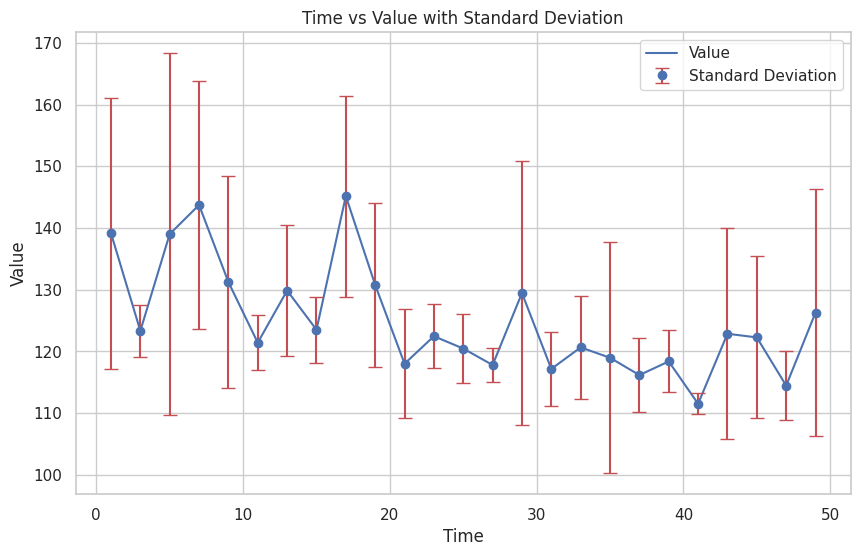

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# data = np.loadtxt("your_data.txt")

# # Separate the columns
# time = data[:, 2]
# value = data[:, 0]
# std_deviation = data[:, 1]

# Plotting

sns.set(style="whitegrid")



plt.figure(figsize=(10, 6))
plt.plot(time, value, color='b', label='Value')
plt.errorbar(time, value, yerr=std_deviation, fmt='o', ecolor='r', capsize=5, label='Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time vs Value with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!cp drive/MyDrive/CS297/Results/Data1/FourierDenseNet/outputs*.pkl drive/MyDrive/CS297/Results/Data1/FourierDenseNet/1

#Dataset - 2

##Load dataset

In [ ]:
beijing_pm2_5 = fetch_ucirepo(id=381)

In [ ]:
raw_df = beijing_pm2_5.data.original
df = raw_df.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=False)
df = df[pd.notna(df["pm2.5"])]
df["cbwd"] = preprocessing.LabelEncoder().fit_transform(df["cbwd"])
df = df[[c for c in df if c not in ['pm2.5']] + ['pm2.5']]

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['pm2.5']]] = xScaler.fit_transform(df[[c for c in df if c not in ['pm2.5']]])
df[["pm2.5"]] = yScaler.fit_transform(df[["pm2.5"]])

##Initialize model parameters

In [ ]:
df.shape

(41757, 8)

In [ ]:
Data = df.values[:10000]
WindowSize = 50
ForecastHorizon = 10
MaskPercentage = 0.0
TrainRatio = 0.8
ValRatio = 0.1
HiddenLayers = 10
HiddenUnits = 20
Epochs = 50
UsePca = True
PcaVarExpRatio = 0.95
MaskLower = False

Epoch 15: early stopping
129/129 [==============================] - 0s 1ms/step


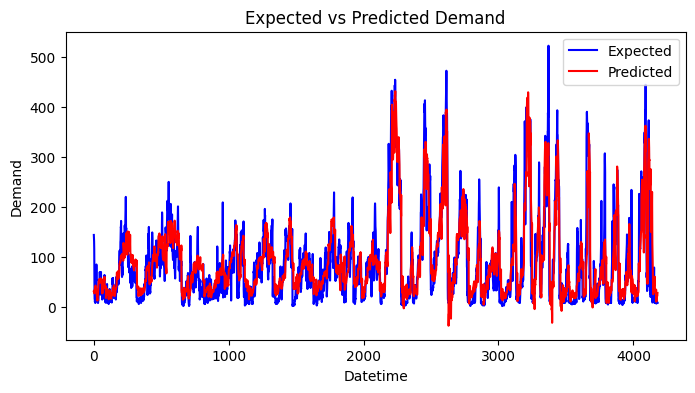

{'Mean Absolute Error': 31.01422697639392,
 'Mean Absolute Percentage Error': 93.16142911570478,
 'Mean Squared Error': 1997.8798843118395,
 'R-squared': 0.7460185555534765,
 'Root Mean Squared Error': 44.69764965086911}
Epoch 14: early stopping
129/129 [==============================] - 0s 1ms/step


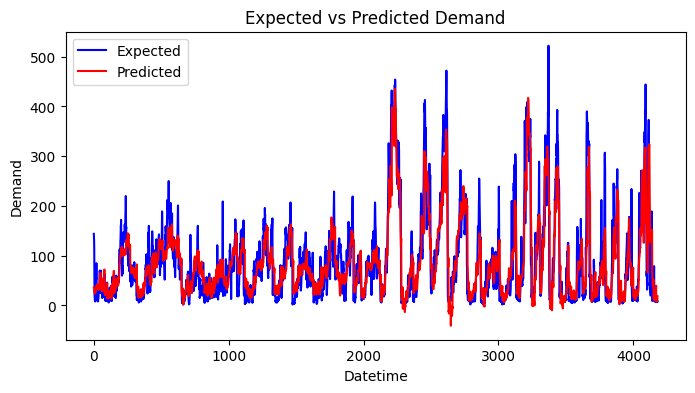

{'Mean Absolute Error': 29.5038195107398,
 'Mean Absolute Percentage Error': 77.82111508460771,
 'Mean Squared Error': 1853.5591861158102,
 'R-squared': 0.7643653939591216,
 'Root Mean Squared Error': 43.05298115248014}
Epoch 15: early stopping
129/129 [==============================] - 0s 1ms/step


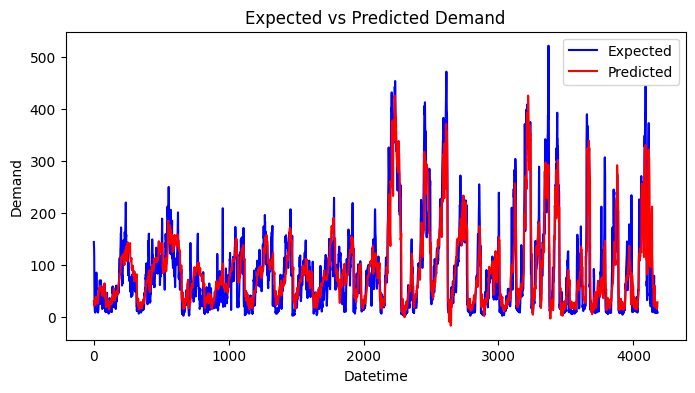

{'Mean Absolute Error': 29.481742848153072,
 'Mean Absolute Percentage Error': 82.29835395868703,
 'Mean Squared Error': 1813.0383733909757,
 'R-squared': 0.7695166218316348,
 'Root Mean Squared Error': 42.57978832017576}
Epoch 23: early stopping
129/129 [==============================] - 0s 1ms/step


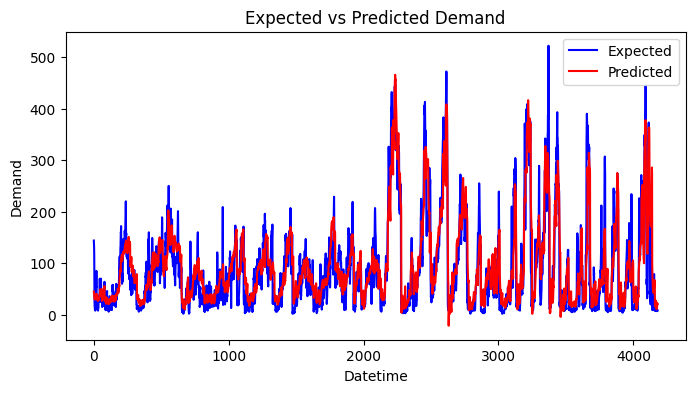

{'Mean Absolute Error': 30.166418921394573,
 'Mean Absolute Percentage Error': 92.41904845003835,
 'Mean Squared Error': 1926.6529999671375,
 'R-squared': 0.7550733075990551,
 'Root Mean Squared Error': 43.89365557762463}
Epoch 14: early stopping
129/129 [==============================] - 0s 2ms/step


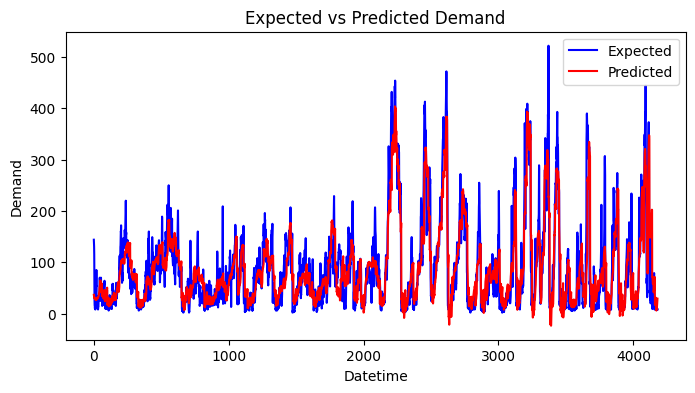

{'Mean Absolute Error': 30.46590715939629,
 'Mean Absolute Percentage Error': 84.10652204672996,
 'Mean Squared Error': 2002.7326345918975,
 'R-squared': 0.7454016473322438,
 'Root Mean Squared Error': 44.75190090478725}
Epoch 20: early stopping
129/129 [==============================] - 0s 2ms/step


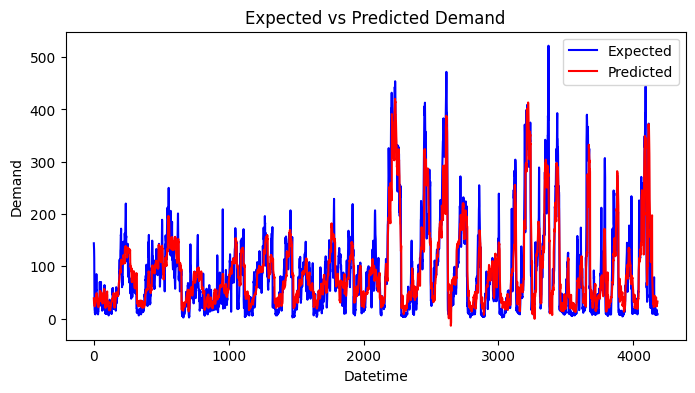

{'Mean Absolute Error': 29.60990557506376,
 'Mean Absolute Percentage Error': 91.5630342862073,
 'Mean Squared Error': 1822.3922984794438,
 'R-squared': 0.7683274995906688,
 'Root Mean Squared Error': 42.6894869784054}
Epoch 16: early stopping
129/129 [==============================] - 0s 2ms/step


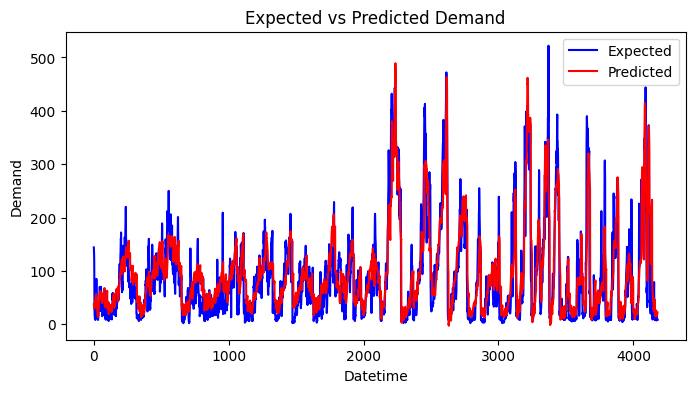

{'Mean Absolute Error': 31.278558804017276,
 'Mean Absolute Percentage Error': 96.72876875623143,
 'Mean Squared Error': 1951.1337191225173,
 'R-squared': 0.7519611843623197,
 'Root Mean Squared Error': 44.17163930762042}
Epoch 15: early stopping
129/129 [==============================] - 0s 1ms/step


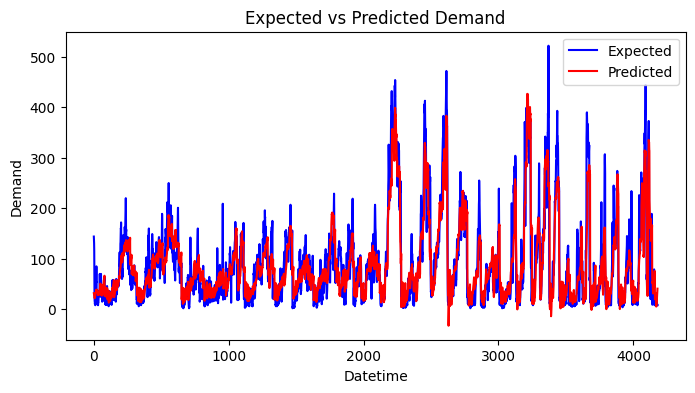

{'Mean Absolute Error': 29.349958917769193,
 'Mean Absolute Percentage Error': 82.68730125604328,
 'Mean Squared Error': 1831.6138261324045,
 'R-squared': 0.7671552084375852,
 'Root Mean Squared Error': 42.79735770035814}
Epoch 30: early stopping
129/129 [==============================] - 0s 2ms/step


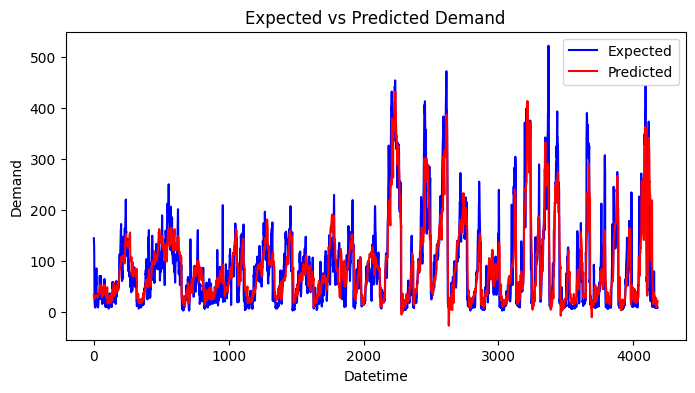

{'Mean Absolute Error': 28.73586675802274,
 'Mean Absolute Percentage Error': 75.69322635824632,
 'Mean Squared Error': 1800.5466187459872,
 'R-squared': 0.7711046421692531,
 'Root Mean Squared Error': 42.4328483458981}
Epoch 15: early stopping
129/129 [==============================] - 0s 2ms/step


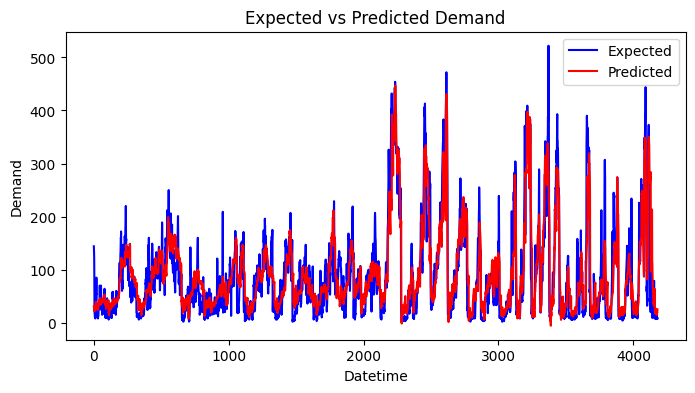

{'Mean Absolute Error': 29.914389638045343,
 'Mean Absolute Percentage Error': 89.12872507319352,
 'Mean Squared Error': 1932.9067097984796,
 'R-squared': 0.7542783017187787,
 'Root Mean Squared Error': 43.96483492290719}


In [ ]:
evaluations = []
for i in range(10):
    fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower)
    information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                    hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio, verbose=False)
    evaluation = evaluate(information["expected"], information["predicted"])
    evaluations.append(evaluation)

In [ ]:
sum_dict = {key: 0 for key in evaluations[0].keys()}
sum_squares_dict = {key: 0 for key in evaluations[0].keys()}

# Calculate the sum and sum of squares of values for each key
for ev in evaluations:
    for key, value in ev.items():
        sum_dict[key] += value
        sum_squares_dict[key] += value ** 2

# Calculate the mean and standard deviation for each key
num_dicts = len(evaluations)
mean_dict = {key: sum_value / num_dicts for key, sum_value in sum_dict.items()}
std_dict = {key: np.sqrt((sum_squares_dict[key] / num_dicts) - (mean_dict[key] ** 2)) for key in sum_dict.keys()}

# Combine mean and std into a tuple under the same key
average_dict = {key: (mean_dict[key], std_dict[key]) for key in mean_dict.keys()}

pprint(average_dict)

{'Mean Absolute Error': (29.952079510899598, 0.7469969605465887),
 'Mean Absolute Percentage Error': (86.56075243856898, 6.68261717885951),
 'Mean Squared Error': (1893.2456250656494, 73.75351801438804),
 'R-squared': (0.7593202362554138, 0.009375951570155349),
 'Root Mean Squared Error': (43.503214286112616, 0.8461511934734266)}


In [ ]:
import itertools

# Input parameters
# inputParametersDict = {
#     "constants": {
#         "Data": df.values[:10000],
#         "TrainRatio": 0.8,
#         "ValRatio": 0.1,
#         "Epochs": 50,
#         "MaskPercentage": 0.0,
#         "HiddenLayers": 8,
#         "HiddenUnits": 12,
#         "UsePca": False,
#         "PcaVarExpRatio": 0.99,
#         "MaskLower": False,
#         "Univariate": False,
#         "ExcludeTargetInTraining": False,
#         "TrainTime": 30,
#         "TargetScaler": yScaler,
#         "Verbose": False
#     },
#     "variables": {
#         "WindowSize": [5, 100, 1],
#         "ForecastHorizon": [5, 100, 1]
#     }
# }


inputParametersDict = {
    "constants": {
        "Data": df.values[:10000],
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "Epochs": 50,
        "MaskPercentage": 0.0,
        "HiddenLayers": 8,
        "HiddenUnits": 12,
        "UsePca": False,
        "PcaVarExpRatio": 0.99,
        "MaskLower": False,
        "Univariate": False,
        "ExcludeTargetInTraining": False,
        "TrainTime": 30,
        "TargetScaler": yScaler,
        "Verbose": False,
        "WindowSize": 50
    },
    "variables": {
        "ForecastHorizon": [1, 50, 2]
    }
}


# Generate combinations of variables
variable_combinations = list(itertools.product(*[range(start, end, step) for start, end, step in inputParametersDict["variables"].values()]))

# Create a list of dictionaries for each combination
inputParameters = []
for combination in variable_combinations:
    parameters = {
        **{key: val for key, val in zip(inputParametersDict["variables"].keys(), combination)},
        **inputParametersDict["constants"],

    }
    inputParameters.append(parameters)


In [ ]:
baseFolder = "drive/MyDrive/CS297/Results/Data2/FourierDenseNet/Window50Horizon1-50-2"
# baseFolder = "drive/MyDrive/CS297/Results/Data1/LSTM"
results = os.listdir(baseFolder)
results = filter(lambda x: x.endswith(".pkl"), results)
outputNums = map(lambda x:int(x.split(".")[0].split("_")[1]), results)
# outputNums = map(results, lambda x:x.split(".")[0].split("_")[1]))
# print(outputNums)
try:
    resumeIndex = max(outputNums)
except ValueError:
    resumeIndex = -1
resumeIndex




-1

In [ ]:
from time import time
for index, params in enumerate(inputParameters):
    if index<=resumeIndex:
        continue
    if params["ForecastHorizon"] > params["WindowSize"]:
        continue
    # print(params)
    print(index+1, "/", len(inputParameters))
    recordingParams = {key: value for key, value in params.items() if key not in ["Data"]}
    paramRunInfo = {"inputParameters": recordingParams, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"],  params["MaskLower"],  params["Univariate"],  params["TrainTime"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                                           hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], usePCA=params["UsePca"], pcaVarExpRatio=params["PcaVarExpRatio"],
                                           excludeTargetInTraining=params["ExcludeTargetInTraining"], targetScaler=params["TargetScaler"], verbose=params["Verbose"])
        paramRunInfo["runs"].append(information)
    with open(baseFolder+"/outputs_"+str(index)+".pkl", "wb") as f:
        pkl.dump(paramRunInfo, f)

1 / 25
Epoch 6: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 6: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 8: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 11: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 9: early stopping
29/29 [==============================] - 0s 3ms/step
2 / 25
Epoch 8: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 6: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 6: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 8: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 6: early stopping
29/29 [==============================] - 0s 2ms/step
3 / 25
Epoch 6: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 12: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 11: early stopping
29/29 [=====================

In [ ]:
outputs = os.listdir(baseFolder)
results = []
for i in outputs:
    with open(os.path.join(baseFolder, i), "rb") as f:
        results.append(pkl.load(f))

timeTaken = []
value = []
std_deviation = []

for d in results:
    mean = 0
    meanTime = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
            # mean+=run["rmse"]
            meanTime+=run["timeTaken"]
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        value.append(mean)
        std_deviation.append(std)
        # print(mean/5, meanTime/5, d["runs"][0]["num_params"], d['inputParameters']["ForecastHorizon"])
        print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
        timeTaken.append(d['inputParameters']["ForecastHorizon"])
        # value.append(mean)
        print("-"*100)
    except Exception as e:
        print(type(d))
        print(e)
        # break

134.32011724637294 1.9774239495349197 1 12004
----------------------------------------------------------------------------------------------------
134.6848748981807 7.765511633390037 3 12004
----------------------------------------------------------------------------------------------------
129.15277602106062 1.9467752585091087 5 12004
----------------------------------------------------------------------------------------------------
128.94042348729727 2.643060241339183 7 12004
----------------------------------------------------------------------------------------------------
126.87518346440436 2.766014302633753 9 12004
----------------------------------------------------------------------------------------------------
125.72718003584866 2.903010837014852 11 12004
----------------------------------------------------------------------------------------------------
124.72178211257992 3.4642602911671263 13 12004
---------------------------------------------------------------------------

#Dataset 3

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip
!unzip PEMS-SF.zip -d data

--2024-05-01 19:55:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘PEMS-SF.zip’

PEMS-SF.zip             [       <=>          ] 104.41M  9.79MB/s    in 12s     

2024-05-01 19:55:59 (8.42 MB/s) - ‘PEMS-SF.zip’ saved [109480788]

Archive:  PEMS-SF.zip
  inflating: data/PEMS_test          
  inflating: data/PEMS_testlabels    
  inflating: data/PEMS_train         
  inflating: data/PEMS_trainlabels   
  inflating: data/randperm           
  inflating: data/stations_list      


In [ ]:
data = pd.read_csv("drive/MyDrive/CS297/Datasets/traffic_features.csv", nrows=10000)
df = data[["values", 'sensor_day', 'time_on_day', 'day_of_week', 'hours_from_start']]
df = df[[c for c in df if c not in ['values']] + ['values']]

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['values']]] = xScaler.fit_transform(df[[c for c in df if c not in ['values']]])
df[["values"]] = yScaler.fit_transform(df[["values"]])

In [ ]:
Data = df.values[:1000]
WindowSize = 50
ForecastHorizon = 10
MaskPercentage = 0.0
TrainRatio = 0.8
ValRatio = 0.1
HiddenLayers = 10
HiddenUnits = 20
Epochs = 50
UsePca = True
PcaVarExpRatio = 0.95
MaskLower = False

Epoch 39: early stopping
2/2 [==============================] - 0s 5ms/step


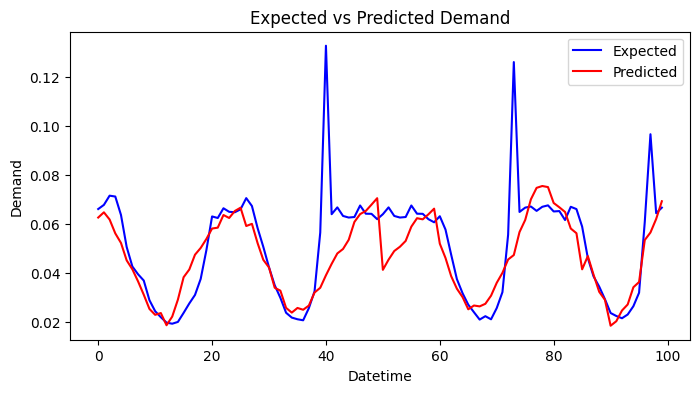

{'Mean Absolute Error': 0.008377810460502441,
 'Mean Absolute Percentage Error': 15.848288586667922,
 'Mean Squared Error': 0.0002339957964900906,
 'R-squared': 0.5037126691952616,
 'Root Mean Squared Error': 0.015296921144141738}
Epoch 39: early stopping
2/2 [==============================] - 0s 6ms/step


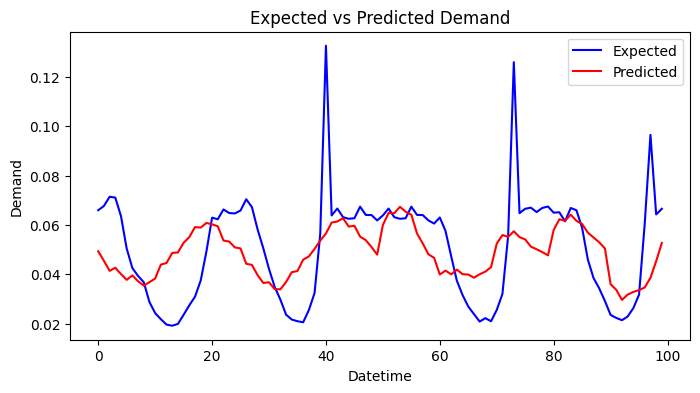

{'Mean Absolute Error': 0.014699894746247553,
 'Mean Absolute Percentage Error': 37.09543753084136,
 'Mean Squared Error': 0.0003753419281450761,
 'R-squared': 0.20392824806101872,
 'Root Mean Squared Error': 0.019373743266211517}
Epoch 24: early stopping
2/2 [==============================] - 0s 12ms/step


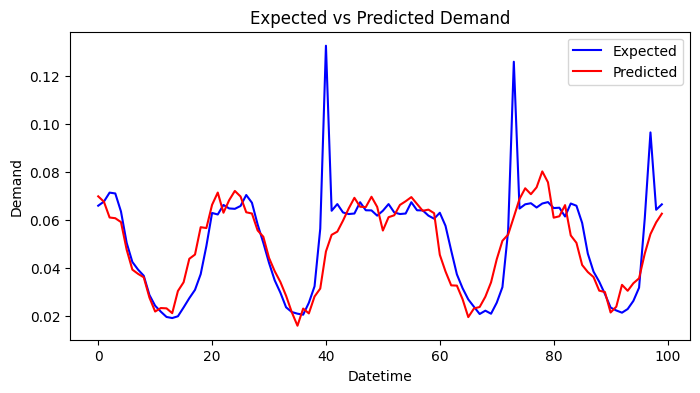

{'Mean Absolute Error': 0.008071793160564276,
 'Mean Absolute Percentage Error': 16.62804454898717,
 'Mean Squared Error': 0.00019916861426843625,
 'R-squared': 0.5775784803059627,
 'Root Mean Squared Error': 0.014112711088534203}
Epoch 44: early stopping
2/2 [==============================] - 0s 6ms/step


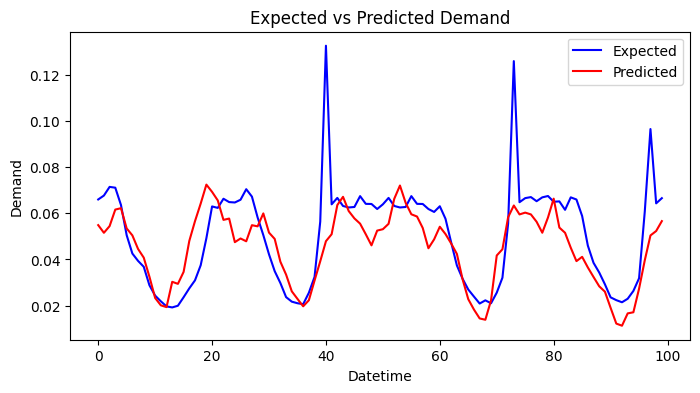

{'Mean Absolute Error': 0.010824054519695986,
 'Mean Absolute Percentage Error': 21.911789441533113,
 'Mean Squared Error': 0.0002521237338542523,
 'R-squared': 0.46526468943492294,
 'Root Mean Squared Error': 0.015878404638194996}
2/2 [==============================] - 0s 6ms/step


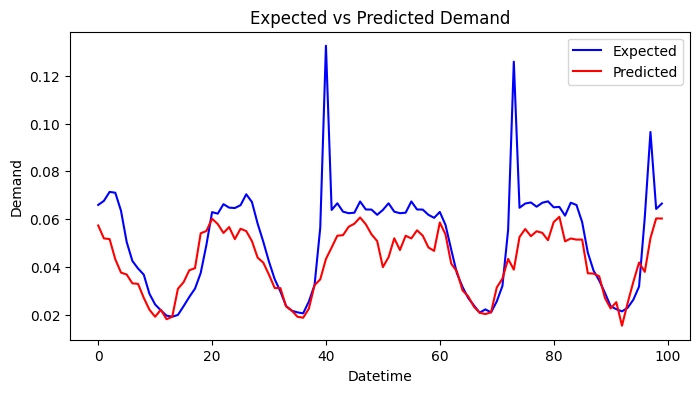

{'Mean Absolute Error': 0.010577529491824342,
 'Mean Absolute Percentage Error': 18.198990990085495,
 'Mean Squared Error': 0.00028687858717513345,
 'R-squared': 0.39155228243507867,
 'Root Mean Squared Error': 0.01693749058081313}
Epoch 41: early stopping
2/2 [==============================] - 0s 10ms/step


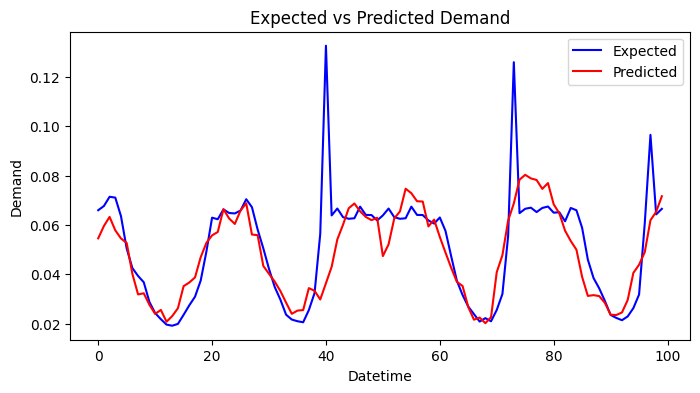

{'Mean Absolute Error': 0.008106347423076645,
 'Mean Absolute Percentage Error': 15.557773124432837,
 'Mean Squared Error': 0.00020552038164171736,
 'R-squared': 0.5641068636236868,
 'Root Mean Squared Error': 0.014335982060595548}
Epoch 31: early stopping
2/2 [==============================] - 0s 5ms/step


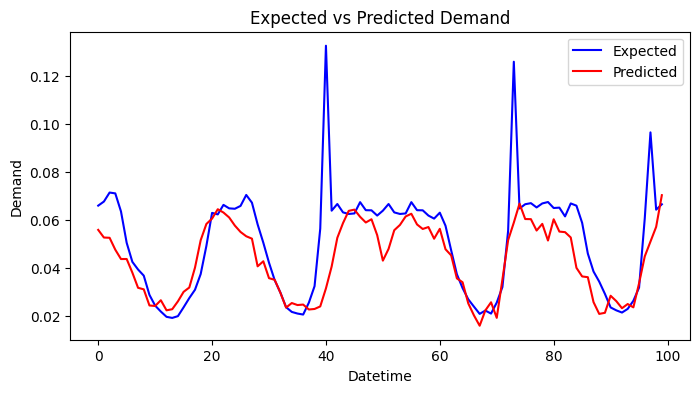

{'Mean Absolute Error': 0.009637701356714306,
 'Mean Absolute Percentage Error': 17.29986780760962,
 'Mean Squared Error': 0.000265684291356558,
 'R-squared': 0.43650377582881694,
 'Root Mean Squared Error': 0.016299824887297348}
Epoch 47: early stopping
2/2 [==============================] - 0s 7ms/step


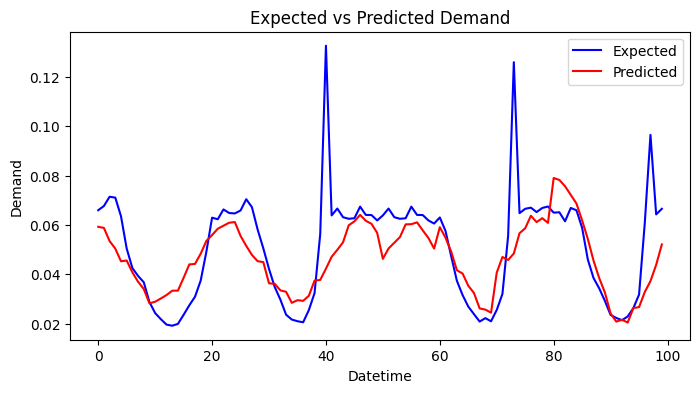

{'Mean Absolute Error': 0.010112337683571431,
 'Mean Absolute Percentage Error': 20.511672540010256,
 'Mean Squared Error': 0.0002721453981721346,
 'R-squared': 0.42280025848515135,
 'Root Mean Squared Error': 0.01649682994311739}
Epoch 32: early stopping
2/2 [==============================] - 0s 5ms/step


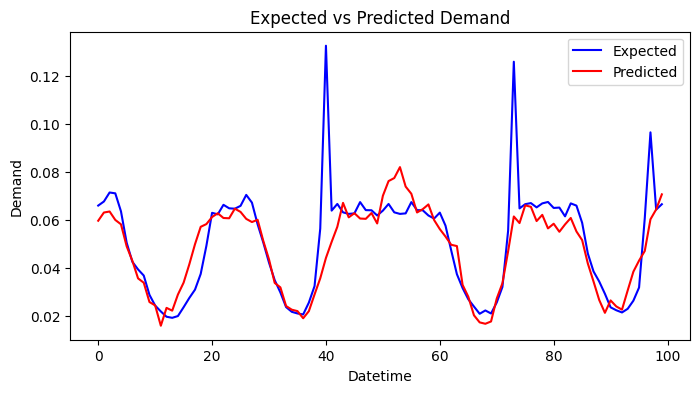

{'Mean Absolute Error': 0.007222035085137826,
 'Mean Absolute Percentage Error': 14.091286173549571,
 'Mean Squared Error': 0.00018407656386816278,
 'R-squared': 0.6095875741523963,
 'Root Mean Squared Error': 0.013567481854351705}
Epoch 46: early stopping
2/2 [==============================] - 0s 5ms/step


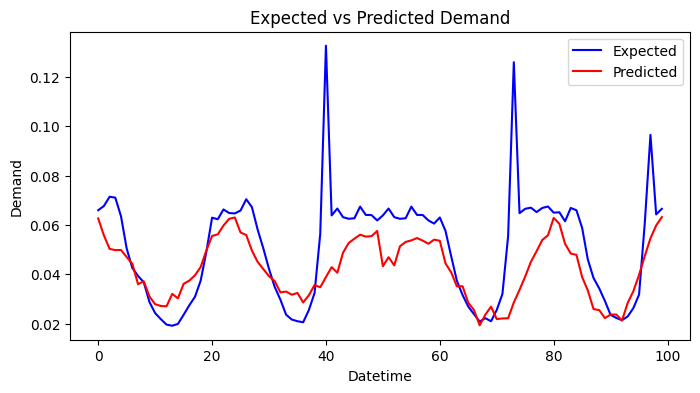

{'Mean Absolute Error': 0.011694895147088958,
 'Mean Absolute Percentage Error': 21.914666772595464,
 'Mean Squared Error': 0.0003388678577725075,
 'R-squared': 0.28128698398836616,
 'Root Mean Squared Error': 0.018408363799439307}


In [ ]:
evaluations = []
for i in range(10):
    fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower)
    information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                    hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio, verbose=False)
    evaluation = evaluate(information["expected"], information["predicted"])
    evaluations.append(evaluation)

In [ ]:
sum_dict = {key: 0 for key in evaluations[0].keys()}
sum_squares_dict = {key: 0 for key in evaluations[0].keys()}

# Calculate the sum and sum of squares of values for each key
for ev in evaluations:
    for key, value in ev.items():
        sum_dict[key] += value
        sum_squares_dict[key] += value ** 2

# Calculate the mean and standard deviation for each key
num_dicts = len(evaluations)
mean_dict = {key: sum_value / num_dicts for key, sum_value in sum_dict.items()}
std_dict = {key: np.sqrt((sum_squares_dict[key] / num_dicts) - (mean_dict[key] ** 2)) for key in sum_dict.keys()}

# Combine mean and std into a tuple under the same key
average_dict = {key: (mean_dict[key], std_dict[key]) for key in mean_dict.keys()}

pprint(average_dict)

{'Mean Absolute Error': (0.009932439907442378, 0.002091052663607437),
 'Mean Absolute Percentage Error': (19.905781751631284, 6.27323941297446),
 'Mean Squared Error': (0.0002613803152744069, 5.7946730380525304e-05),
 'R-squared': (0.44563218255106624, 0.12290061864692788),
 'Root Mean Squared Error': (0.016070775326269687, 0.0017636597424016689)}


In [ ]:
import itertools

# Input parameters
# inputParametersDict = {
#     "constants": {
#         "Data": df.values[:10000],
#         "TrainRatio": 0.8,
#         "ValRatio": 0.1,
#         "Epochs": 50,
#         "MaskPercentage": 0.0,
#         "HiddenLayers": 8,
#         "HiddenUnits": 12,
#         "UsePca": False,
#         "PcaVarExpRatio": 0.99,
#         "MaskLower": False,
#         "Univariate": False,
#         "ExcludeTargetInTraining": False,
#         "TrainTime": 30,
#         "TargetScaler": yScaler,
#         "Verbose": False
#     },
#     "variables": {
#         "WindowSize": [5, 100, 1],
#         "ForecastHorizon": [5, 100, 1]
#     }
# }


inputParametersDict = {
    "constants": {
        "Data": df.values[:10000],
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "Epochs": 50,
        "MaskPercentage": 0.0,
        "HiddenLayers": 8,
        "HiddenUnits": 12,
        "UsePca": False,
        "PcaVarExpRatio": 0.99,
        "MaskLower": False,
        "Univariate": False,
        "ExcludeTargetInTraining": False,
        "TrainTime": 30,
        "TargetScaler": yScaler,
        "Verbose": False,
        "WindowSize": 50
    },
    "variables": {
        "ForecastHorizon": [1, 50, 2]
    }
}


# Generate combinations of variables
variable_combinations = list(itertools.product(*[range(start, end, step) for start, end, step in inputParametersDict["variables"].values()]))

# Create a list of dictionaries for each combination
inputParameters = []
for combination in variable_combinations:
    parameters = {
        **{key: val for key, val in zip(inputParametersDict["variables"].keys(), combination)},
        **inputParametersDict["constants"],

    }
    inputParameters.append(parameters)


In [ ]:
baseFolder = "drive/MyDrive/CS297/Results/Data3/FourierDenseNet/Window50Horizon1-50-2"
# baseFolder = "drive/MyDrive/CS297/Results/Data1/LSTM"
results = os.listdir(baseFolder)
results = filter(lambda x: x.endswith(".pkl"), results)
outputNums = map(lambda x:int(x.split(".")[0].split("_")[1]), results)
# outputNums = map(results, lambda x:x.split(".")[0].split("_")[1]))
# print(outputNums)
try:
    resumeIndex = max(outputNums)
except ValueError:
    resumeIndex = -1
resumeIndex




-1

In [ ]:
from time import time
for index, params in enumerate(inputParameters):
    if index<=resumeIndex:
        continue
    if params["ForecastHorizon"] > params["WindowSize"]:
        continue
    # print(params)
    print(index+1, "/", len(inputParameters))
    recordingParams = {key: value for key, value in params.items() if key not in ["Data"]}
    paramRunInfo = {"inputParameters": recordingParams, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"],  params["MaskLower"],  params["Univariate"],  params["TrainTime"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                                           hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], usePCA=params["UsePca"], pcaVarExpRatio=params["PcaVarExpRatio"],
                                           excludeTargetInTraining=params["ExcludeTargetInTraining"], targetScaler=params["TargetScaler"], verbose=params["Verbose"])
        paramRunInfo["runs"].append(information)
    with open(baseFolder+"/outputs_"+str(index)+".pkl", "wb") as f:
        pkl.dump(paramRunInfo, f)

1 / 25
Epoch 24: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 28: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 26: early stopping
29/29 [==============================] - 0s 1ms/step
Epoch 28: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 25: early stopping
29/29 [==============================] - 0s 1ms/step
2 / 25
Epoch 33: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 33: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 20: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 26: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 22: early stopping
29/29 [==============================] - 0s 3ms/step
3 / 25
Epoch 38: early stopping
29/29 [==============================] - 0s 2ms/step
Epoch 31: early stopping
29/29 [==============================] - 0s 3ms/step
Epoch 21: early stopping
29/29 [===========

In [ ]:
outputs = os.listdir(baseFolder)
results = []
for i in outputs:
    with open(os.path.join(baseFolder, i), "rb") as f:
        results.append(pkl.load(f))

timeTaken = []
value = []
std_deviation = []

for d in results:
    mean = 0
    meanTime = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
            # mean+=run["rmse"]
            meanTime+=run["timeTaken"]
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        value.append(mean)
        std_deviation.append(std)
        # print(mean/5, meanTime/5, d["runs"][0]["num_params"], d['inputParameters']["ForecastHorizon"])
        print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
        timeTaken.append(d['inputParameters']["ForecastHorizon"])
        # value.append(mean)
        print("-"*100)
    except Exception as e:
        print(type(d))
        print(e)
        # break

0.054919600038348906 0.002051631108364092 1 8404
----------------------------------------------------------------------------------------------------
0.053248026176020626 0.0010418578432427762 3 8404
----------------------------------------------------------------------------------------------------
0.05341581261793284 0.0023082619342192205 5 8404
----------------------------------------------------------------------------------------------------
0.05506830708552694 0.007034809391599026 7 8404
----------------------------------------------------------------------------------------------------
0.05110831035417984 0.0011358390205663093 9 8404
----------------------------------------------------------------------------------------------------
0.05158283711119751 0.002013983895499135 11 8404
----------------------------------------------------------------------------------------------------
0.05203214239765643 0.0013757196281668194 13 8404
--------------------------------------------------

#CMAPSS

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
linearDf = pd.read_csv("preprocessed_train_FD001_linear.txt")
# linearDf = linearDf.drop(["Unnamed: 0", "unit", "time cycles"], axis=1)
linearDf = linearDf.drop(["Unnamed: 0"], axis=1)

In [ ]:
linearDfUnitGroups = linearDf.groupby("unit")

In [ ]:
groups = linearDfUnitGroups.groups
groupKeys = groups.keys()

In [ ]:
groupDf["RUL"].iloc[0]

286

In [ ]:
dfs = []
for groupKey in groupKeys:
    groupDf = linearDf.iloc[groups[groupKey]]
    groupDf["RUL"] = decay_sequence(groupDf["RUL"].iloc[0], 1, len(groupDf["RUL"]))
    dfs.append(groupDf)
    # print(groupDf)
    # break

<ipython-input-41-006330939258>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupDf["RUL"] = decay_sequence(groupDf["RUL"].iloc[0], 1, len(groupDf["RUL"]))


In [ ]:
mergedDf = pd.concat(dfs, ignore_index=True)
expDf = mergedDf.drop(["unit", "time cycles"], axis=1)

In [ ]:
expDf

op setting 1  op setting 2  sensor 2  sensor 3  sensor 4  sensor 6  \
0         -0.315980     -1.372953 -1.721725 -0.134255 -0.925936  0.141683   
1          0.872722     -1.031720 -1.061780  0.211528 -0.643726  0.141683   
2         -1.961874      1.015677 -0.661813 -0.413166 -0.525953  0.141683   
3          0.324090     -0.008022 -0.661813 -1.261314 -0.784831  0.141683   
4         -0.864611     -0.690488 -0.621816 -1.251528 -0.301518  0.141683   
...             ...           ...       ...       ...       ...       ...   
20626     -0.178822     -1.031720  1.618000  1.216258  2.188375  0.141683   
20627     -0.727453     -1.714186  1.717992  2.279706  2.738351  0.141683   
20628      0.186933     -0.008022  1.478011  1.946971  2.138377  0.141683   
20629     -0.498857      1.015677  1.098043  2.403666  1.955051  0.141683   
20630     -1.458962     -1.714186  2.337940  1.607712  2.578358  0.141683   

       sensor 7  sensor 8  sensor 9  sensor 11  sensor 12  sensor 13  \
0      1.121141 -0.516338 -0.862813  -0.266467   0.334262  -1.058890   
1      0.431930 -0.798093 -0.958818  -0.191583   1.174899  -0.363646   
2      1.008155 -0.234584 -0.557139  -1.015303   1.364721  -0.919841   
3      1.222827  0.188048 -0.713826  -1.539489   1.961302  -0.224597   
4      0.714393 -0.516338 -0.457059  -0.977861   1.052871  -0.780793   
...         ...       ...       ...        ...        ...        ...   
20626 -2.189329  1.315066  0.012547   1.980044  -2.607969   2.278282   
20627 -2.833345  1.878576 -0.006020   1.867718  -2.350355   1.722087   
20628 -2.742957  2.019453  0.029755   2.054927  -1.902919   2.000184   
20629 -3.036719  2.160330  0.383884   3.178182  -2.363913   1.861136   
20630 -2.912435  2.301208 -0.170405   2.466787  -2.865584   2.278282   

       sensor 14  sensor 15  sensor 17  sensor 20  sensor 21         RUL  
0      -0.269071  -0.603816  -0.781710   1.348493   1.194427  191.000000  
1      -0.642845  -0.275852  -0.781710   1.016528   1.236922  185.819285  
2      -0.551629  -0.649144  -2.073094   0.739891   0.503423  180.779092  
3      -0.520176  -1.971665  -0.781710   0.352598   0.777792  175.875611  
4      -0.521748  -0.339845  -0.136018   0.463253   1.059552  171.105132  
...          ...        ...        ...        ...        ...         ...  
20626  -0.322542   1.425294   2.446751  -1.805173  -2.921113    1.112265  
20627  -0.380207   1.913240   1.155367  -2.856395  -1.203764    1.083069  
20628  -0.141684   3.265092   3.092444  -2.081810  -3.292481    1.054640  
20629  -0.233948   2.579834   1.155367  -2.911722  -2.085072    1.026956  
20630  -0.336696   1.638604   1.801059  -2.469103  -2.194080    1.000000  

[20631 rows x 18 columns]

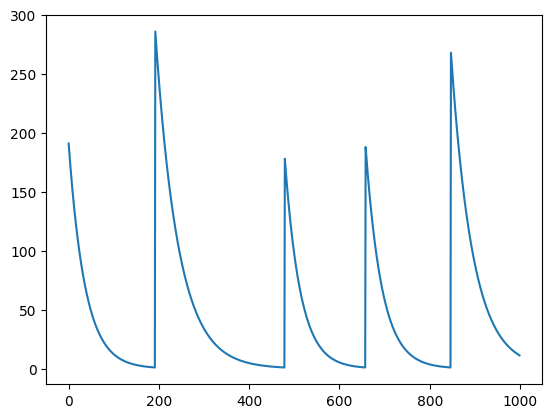

In [ ]:
# plt.plot(linearDf["RUL"][:1000])
plt.plot(mergedDf["RUL"][:1000])

In [ ]:
piecewiseDf = pd.read_csv("preprocessed_train_FD001_piecewise.txt")
piecewiseDf = piecewiseDf.drop(["Unnamed: 0"], axis=1)

In [ ]:
linearDfU1 = linearDf[linearDf["unit"]==1]
linearDfU1 = linearDfU1.drop(["unit"], axis=1)

In [ ]:
import numpy as np

def decay_sequence(start, end, length, decay_type='exponential'):
    if decay_type == 'exponential':
        decay_rate = np.log(end / start) / (length - 1)
        seq = np.array([start * np.exp(decay_rate * i) for i in range(length)])
    elif decay_type == 'logarithmic':
        decay_rate = np.log(start / end) / (length - 1)
        seq = np.array([start * np.exp(-decay_rate * i) for i in range(length)])
    else:
        raise ValueError("Decay type must be 'exponential' or 'logarithmic'")

    return seq

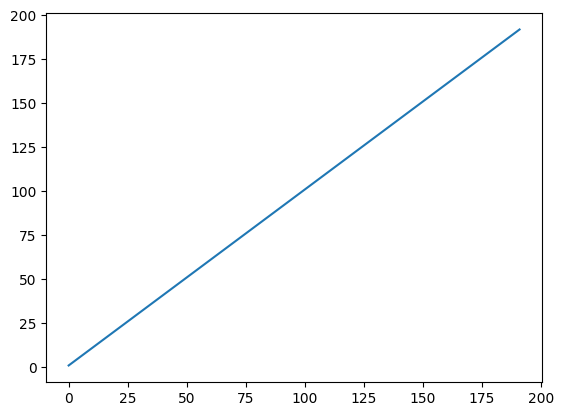

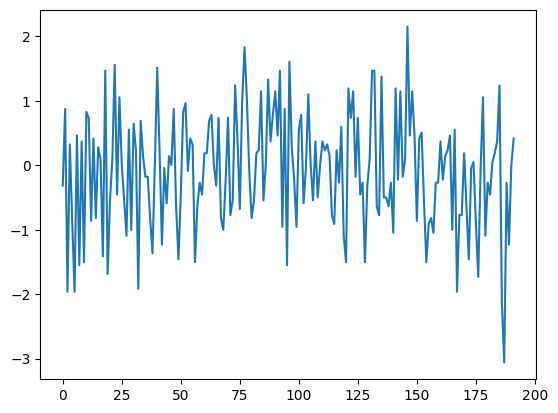

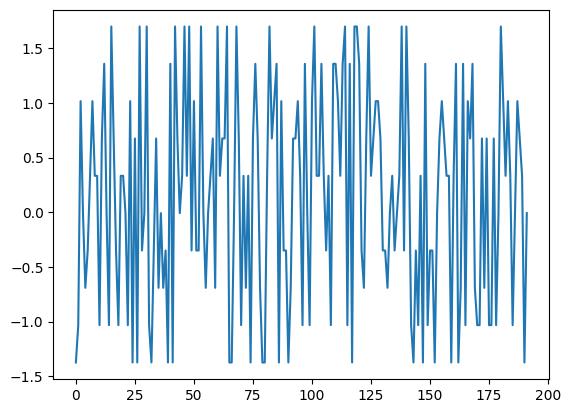

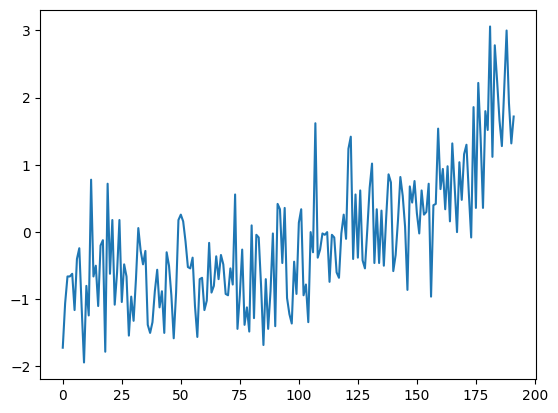

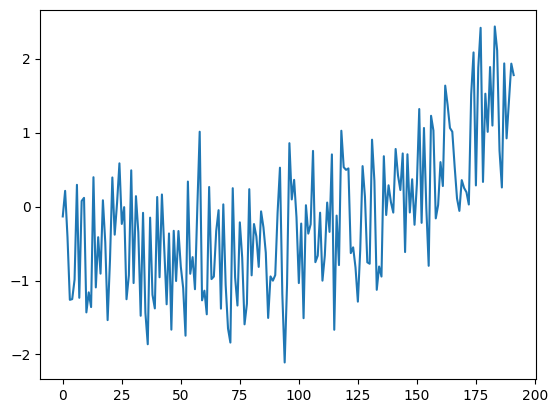

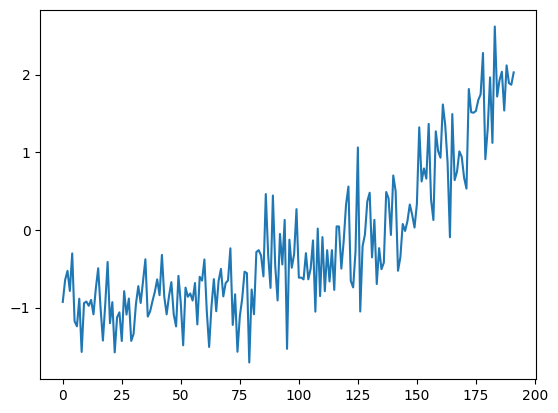

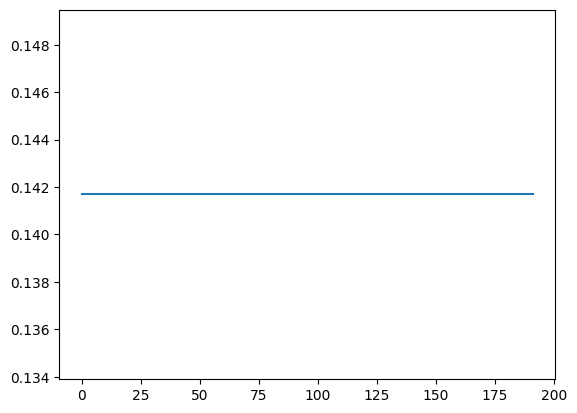

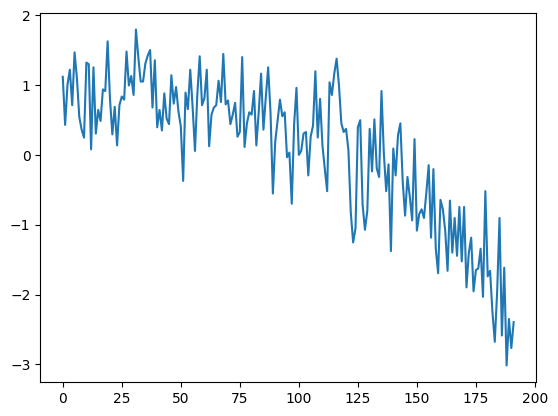

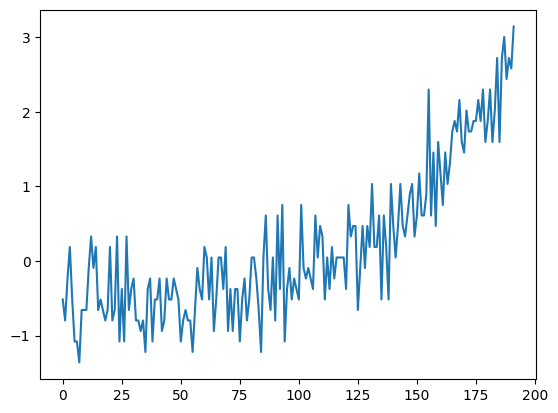

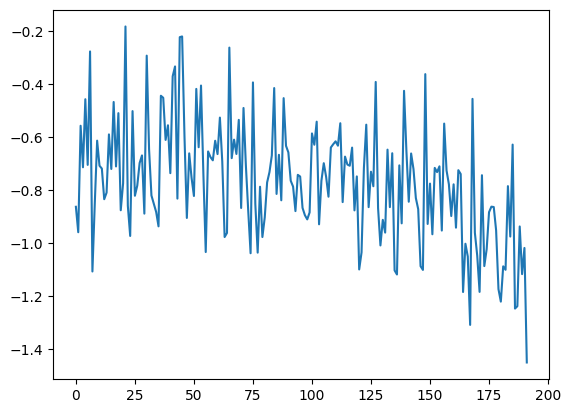

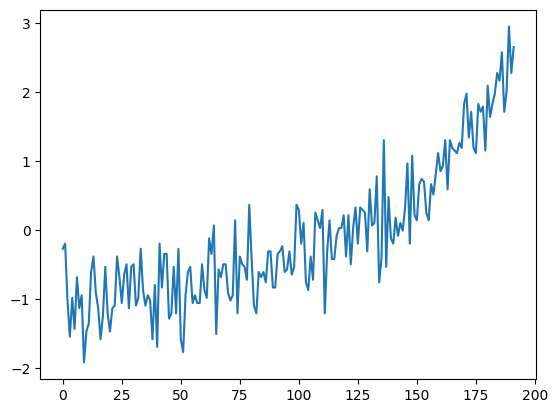

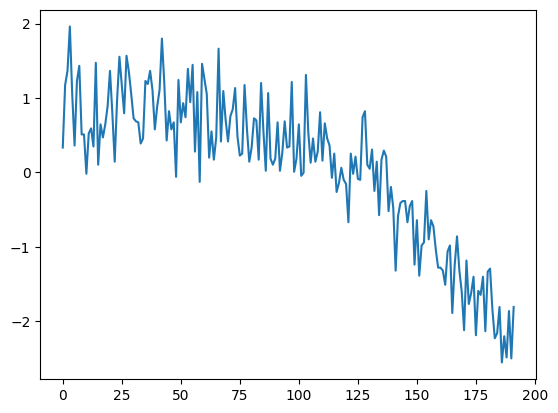

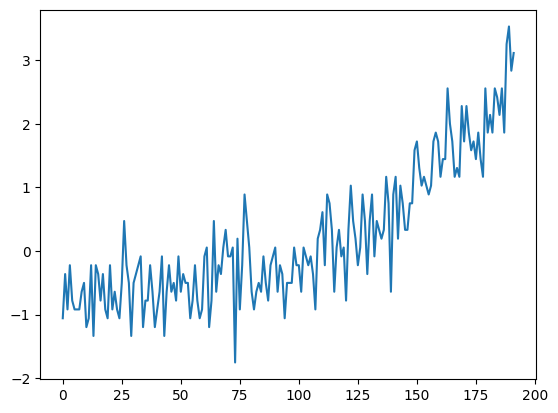

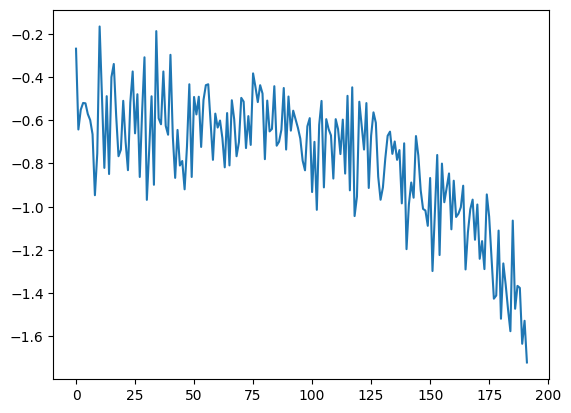

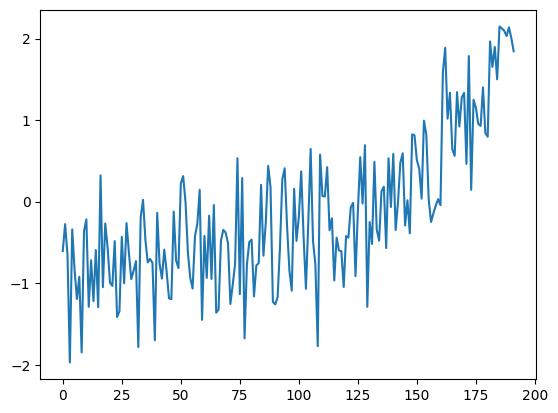

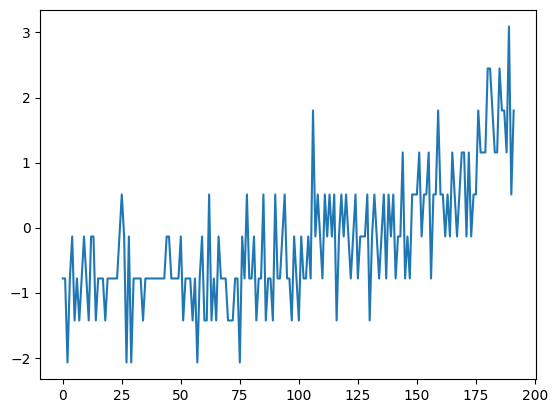

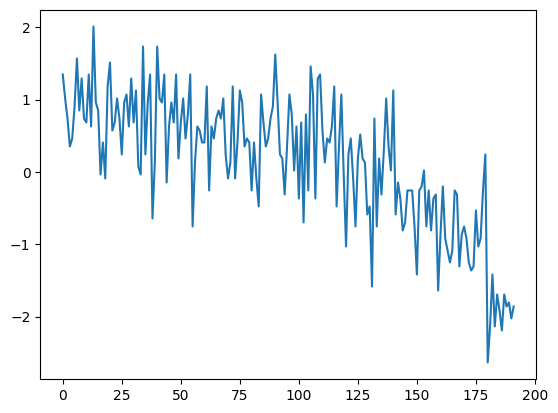

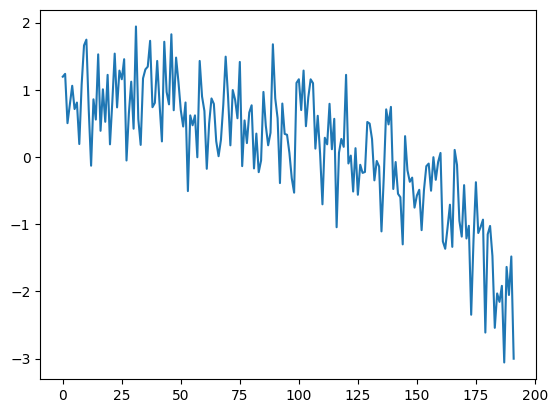

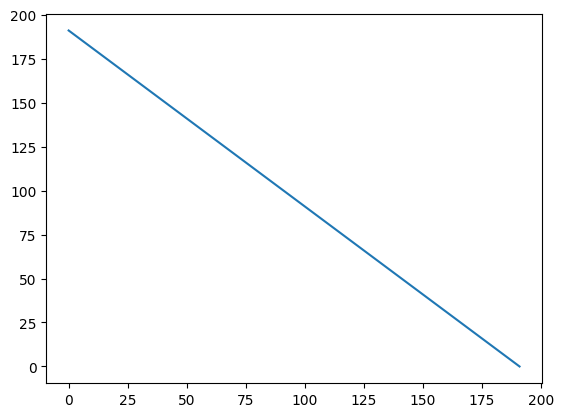

In [ ]:
for i in linearDfU1.columns:
    plt.plot(linearDfU1[i])
    plt.show()

In [ ]:
min, max, L

(0, 191, 192)

In [ ]:

min = linearDfU1["RUL"].min()
max = linearDfU1["RUL"].max()
L = linearDfU1.shape[0]
exponentialDecay = decay_sequence(max, 1, L)
# exponentialDecay
linearDfU1["RUL"] = exponentialDecay

NameError: name 'linearDfU1' is not defined

In [ ]:
xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
linearDfU1[[c for c in linearDfU1 if c not in ['RUL']]] = xScaler.fit_transform(linearDfU1[[c for c in linearDfU1 if c not in ['RUL']]])
linearDfU1[["RUL"]] = yScaler.fit_transform(linearDfU1[["RUL"]])

In [ ]:
xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
linearDf[[c for c in linearDf if c not in ['RUL']]] = xScaler.fit_transform(linearDf[[c for c in linearDf if c not in ['RUL']]])
linearDf[["RUL"]] = yScaler.fit_transform(linearDf[["RUL"]])

In [ ]:
xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
expDf[[c for c in expDf if c not in ['RUL']]] = xScaler.fit_transform(expDf[[c for c in expDf if c not in ['RUL']]])
expDf[["RUL"]] = yScaler.fit_transform(expDf[["RUL"]])

In [ ]:
len(linearDfU1.columns)

19

In [ ]:
fourierModule.X_train.shape

(134, 190)

In [ ]:
arr = np.load('windowed_train_data.npy', allow_pickle=True)
target = np.load('windowed_train_targets.npy', allow_pickle=True)
target = target.reshape(list(target.shape)+[1])
# import pickle
# arr = None
# with open('windowed_train_data.npy', "rb") as f:
#     arr = pickle.load(f)

In [ ]:
arr.shape, target.shape

((17631, 30, 17), (17631, 1, 1))

In [ ]:
inputData = np.concatenate([arr, target], axis=1)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 17 and the array at index 1 has size 1

In [ ]:
fourierModule.X_train.shape

(7000, 400)

In [ ]:
fourierModule.X_train.shape

(7000, 98)

In [ ]:
Data = linearDf.values[:10000]
# Data = expDf.values#[:10000]
WindowSize = 10
ForecastHorizon = 1
MaskPercentage = 0.0
TrainRatio = 0.7
ValRatio = 0.1
HiddenLayers = 10
HiddenUnits = 10
Epochs = 50
UsePca = True
PcaVarExpRatio = 0.95
MaskLower = False
Univariate = False
targetScaler = yScaler
ExcludeTargetInTraining = False
TrainTime = -1

{'X_test_shape': (1981, 98),
 'originalX_test_shape': (1981, 20, 10),
 'originalY_test_shape': (1981, 10),
 'y_test_shape': (1981, 20)}
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_311 (Dense)           (None, 10)                990       
                                                                 
 dense_312 (Dense)           (None, 10)                110       
                                                                 
 dense_313 (Dense)           (None, 10)                110       
                                                                 
 dense_314 (Dense)           (None, 10)                110       
                                                                 
 dense_315 (Dense)           (None, 10)                110       
                                                                 
 dense_316 (Dense)           (None, 10)          

<ipython-input-4-83ba9f5c0eb8>:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((expected - predicted) / expected)) * 100


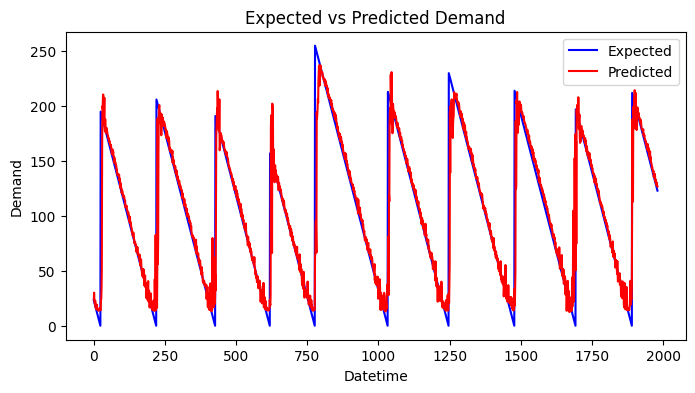

{'Mean Absolute Error': 9.066685006045926,
 'Mean Absolute Percentage Error': inf,
 'Mean Squared Error': 655.4149648876734,
 'R-squared': 0.8361304604349631,
 'Root Mean Squared Error': 25.601073510454075}


In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate, TrainTime)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs,
                usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio, verbose=True, targetScaler=targetScaler, excludeTargetInTraining=ExcludeTargetInTraining)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

{'X_test_shape': (4107, 103),
 'originalX_test_shape': (4107, 18, 10),
 'originalY_test_shape': (4107, 10),
 'y_test_shape': (4107, 20)}
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_278 (Dense)           (None, 10)                1040      
                                                                 
 dense_279 (Dense)           (None, 10)                110       
                                                                 
 dense_280 (Dense)           (None, 10)                110       
                                                                 
 dense_281 (Dense)           (None, 10)                110       
                                                                 
 dense_282 (Dense)           (None, 10)                110       
                                                                 
 dense_283 (Dense)           (None, 10)         

<ipython-input-4-83ba9f5c0eb8>:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((expected - predicted) / expected)) * 100


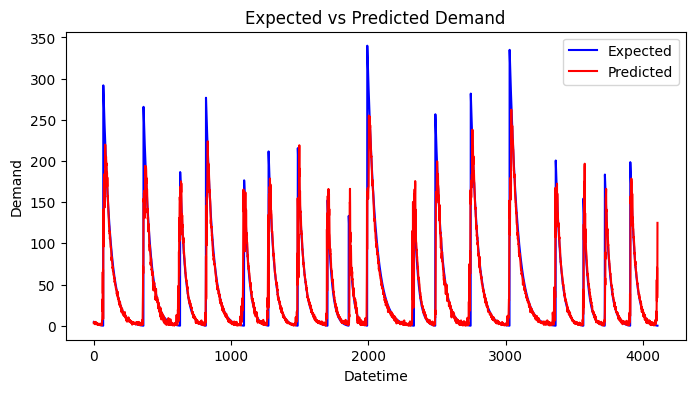

{'Mean Absolute Error': 8.29274066703749,
 'Mean Absolute Percentage Error': inf,
 'Mean Squared Error': 643.1230668361395,
 'R-squared': 0.826799729374764,
 'Root Mean Squared Error': 25.35987119123714}


In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs,
                usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio, verbose=True, targetScaler=targetScaler, excludeTargetInTraining=ExcludeTargetInTraining)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

In [ ]:
fourierModule = FourierInformedTimeSeriesForecaster(Data, WindowSize, ForecastHorizon, MaskPercentage, MaskLower, Univariate)
information = fourierModule.driver(trainRatio=TrainRatio, valRatio=ValRatio,
                hiddenLayers=HiddenLayers, hiddenUnits=HiddenUnits, epochs=Epochs, usePCA=UsePca, pcaVarExpRatio=PcaVarExpRatio, verbose=False, yScaler=targetScaler)
evaluation = evaluate(information["expected"], information["predicted"])
# evaluations.append(evaluation)

TypeError: FourierInformedTimeSeriesForecaster.__init__() takes 5 positional arguments but 7 were given

#Results

##Dataset - 1

In [ ]:
fourierDenseNetFolder = "drive/MyDrive/CS297/Results/Data1/FourierDenseNet/Window50Horizon1-50-2"
lstmFolder = "drive/MyDrive/CS297/Results/Data1/LSTM/Window50Horizon1-50-2"
fourierErrorMean = []
fourierErrorStd = []

lstmErrorMean = []
lstmErrorStd = []

print(fourierDenseNetFolder)
outputs = os.listdir(fourierDenseNetFolder)
results = []
for i in outputs:
    with open(os.path.join(fourierDenseNetFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        fourierErrorMean.append(mean)
        fourierErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)


outputs = os.listdir(lstmFolder)
results = []
for i in outputs:
    with open(os.path.join(lstmFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        lstmErrorMean.append(mean)
        lstmErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)

drive/MyDrive/CS297/Results/Data1/FourierDenseNet/Window50Horizon1-50-2


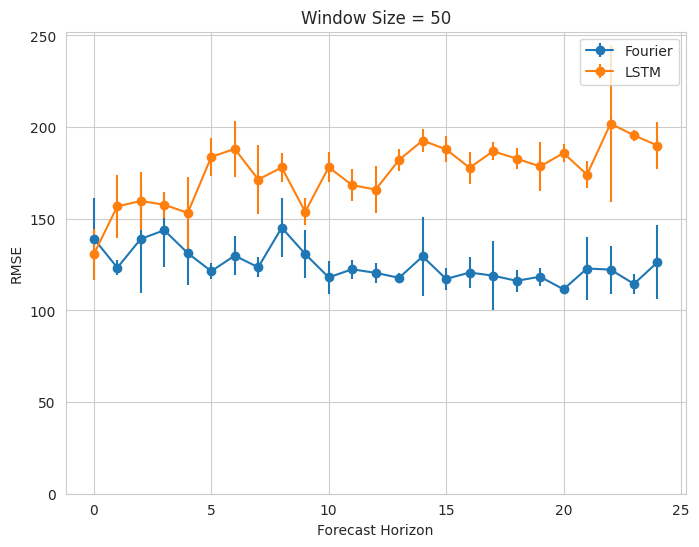

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Time points (assuming you have this list)
timepoints = list(range(len(fourierErrorMean)))

# Create a seaborn style plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plotting the mean values with error bars
# plt.errorbar(timepoints, mean_values, yerr=std_devs, fmt='-o', label='Signal')
plt.errorbar(timepoints, fourierErrorMean, yerr=fourierErrorStd, fmt='-o', label='Fourier')
plt.errorbar(timepoints, lstmErrorMean, yerr=lstmErrorStd, fmt='-o', label='LSTM')

# Labeling the axes
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.title("Window Size = 50")
# Adding legend
plt.legend()
plt.ylim(bottom=0)  # Adjust as needed

# Showing the plot
plt.show()


##Dataset - 2

In [ ]:
fourierDenseNetFolder = "drive/MyDrive/CS297/Results/Data2/FourierDenseNet/Window50Horizon1-50-2"
lstmFolder = "drive/MyDrive/CS297/Results/Data2/LSTM/Window50Horizon1-50-2"
fourierErrorMean = []
fourierErrorStd = []

lstmErrorMean = []
lstmErrorStd = []

print(fourierDenseNetFolder)
outputs = os.listdir(fourierDenseNetFolder)
results = []
for i in outputs:
    with open(os.path.join(fourierDenseNetFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        fourierErrorMean.append(mean)
        fourierErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)


outputs = os.listdir(lstmFolder)
results = []
for i in outputs:
    with open(os.path.join(lstmFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        lstmErrorMean.append(mean)
        lstmErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)

drive/MyDrive/CS297/Results/Data2/FourierDenseNet/Window50Horizon1-50-2


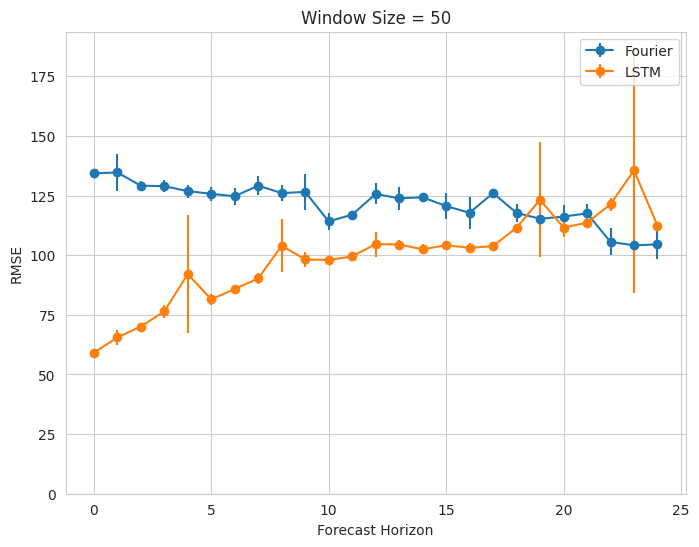

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Time points (assuming you have this list)
timepoints = list(range(len(fourierErrorMean)))

# Create a seaborn style plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plotting the mean values with error bars
# plt.errorbar(timepoints, mean_values, yerr=std_devs, fmt='-o', label='Signal')
plt.errorbar(timepoints, fourierErrorMean, yerr=fourierErrorStd, fmt='-o', label='Fourier')
plt.errorbar(timepoints, lstmErrorMean, yerr=lstmErrorStd, fmt='-o', label='LSTM')

# Labeling the axes
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.title("Window Size = 50")

# Adding legend
plt.legend()
plt.ylim(bottom=0)  # Adjust as needed

# Showing the plot
plt.show()


##Dataset - 3

In [ ]:
fourierDenseNetFolder = "drive/MyDrive/CS297/Results/Data1/FourierDenseNet/Window20Horizon1-20-2"
lstmFolder = "drive/MyDrive/CS297/Results/Data1/LSTM/Window20Horizon1-20-2"
fourierErrorMean = []
fourierErrorStd = []

lstmErrorMean = []
lstmErrorStd = []

print(fourierDenseNetFolder)
outputs = os.listdir(fourierDenseNetFolder)
results = []
for i in outputs:
    with open(os.path.join(fourierDenseNetFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        fourierErrorMean.append(mean)
        fourierErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)


outputs = os.listdir(lstmFolder)
results = []
for i in outputs:
    with open(os.path.join(lstmFolder, i), "rb") as f:
        results.append(pkl.load(f))
for d in results:
    mean = 0
    try:
        val = []
        for run in d["runs"]:
            # print(run["mse"])
            val.append(run["rmse"])
        mean = np.mean(np.array(val))
        std = np.std(np.array(val))
        lstmErrorMean.append(mean)
        lstmErrorStd.append(std)
        # print(mean, std, d['inputParameters']["ForecastHorizon"], d["runs"][0]["num_params"])
    except Exception as e:
        print(type(d))
        print(e)

drive/MyDrive/CS297/Results/Data1/FourierDenseNet/Window20Horizon1-20-2


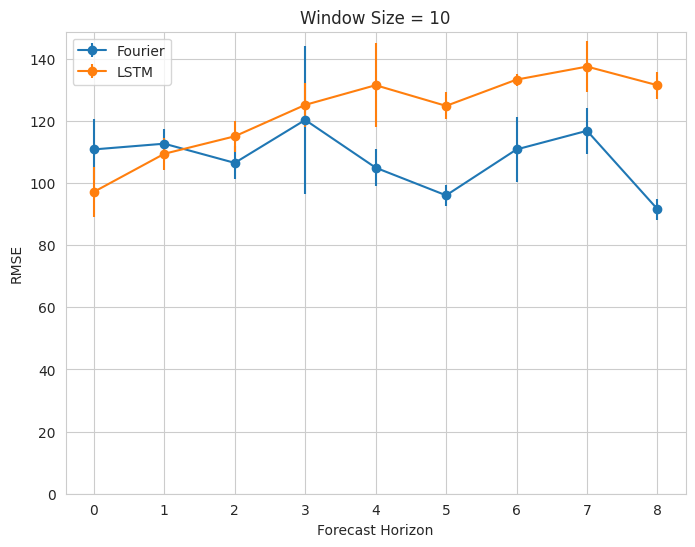

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Time points (assuming you have this list)
timepoints = list(range(0, len(fourierErrorMean), 1))

# Create a seaborn style plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plotting the mean values with error bars
# plt.errorbar(timepoints, mean_values, yerr=std_devs, fmt='-o', label='Signal')
plt.errorbar(timepoints, fourierErrorMean, yerr=fourierErrorStd, fmt='-o', label='Fourier')
plt.errorbar(timepoints, lstmErrorMean, yerr=lstmErrorStd, fmt='-o', label='LSTM')

# Labeling the axes
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.title("Window Size = 10")

# Adding legend
plt.legend()
plt.ylim(bottom=0)  # Adjust as needed

# Showing the plot
plt.show()


Figure out other metrics as in, what type of experimental cascdes can be run?
What if don't want to see next prediction, multiple lookbacks

What if I could replace sequential data with attention mechanisms? Can it beat fourier informed models? Etc

how to reduce computational complexity of baseline model?

In [ ]:
len(fourierErrorMean)

10

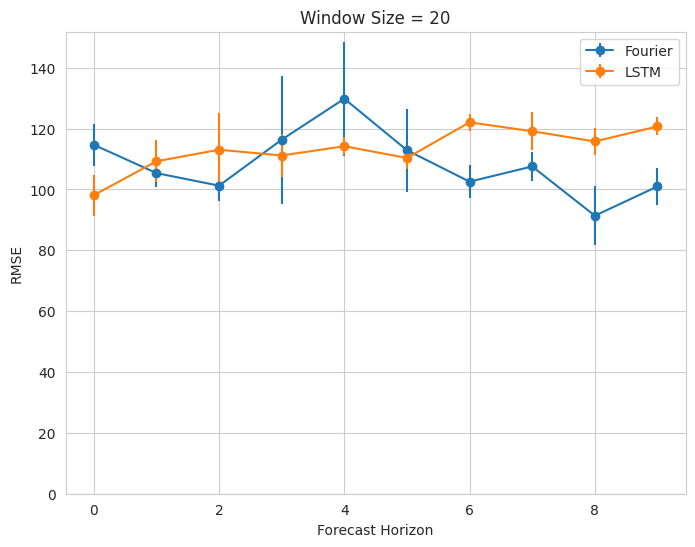

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Time points (assuming you have this list)
timepoints = list(range(0, len(fourierErrorMean), 1))

# Create a seaborn style plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plotting the mean values with error bars
# plt.errorbar(timepoints, mean_values, yerr=std_devs, fmt='-o', label='Signal')
plt.errorbar(timepoints, fourierErrorMean, yerr=fourierErrorStd, fmt='-o', label='Fourier')
plt.errorbar(timepoints, lstmErrorMean, yerr=lstmErrorStd, fmt='-o', label='LSTM')

# Labeling the axes
plt.xlabel('Forecast Horizon')
plt.ylabel('RMSE')
plt.title("Window Size = 20")

# Adding legend
plt.legend()
plt.ylim(bottom=0)  # Adjust as needed

# Showing the plot
plt.show()
